# Hurricane Impact on Florida Real Estate Value

**Final Project: Analyzed the impact of five different hurricanes on Florida Real Estate value using data sourced from Zillow and The National Oceanic and Atmospheric Administration (NOAA).**


## Summary

For my capstone project at Flatiron School I used machine learning and classification models to analyze hurricane impact on real estate value. Data from NOAA and Zillow were used to provide the features for the model. The target value was whether or not homes in a region increased in value (encoded as a boolean). If the percentage change in the value of a home was in the 75th percentile or greater six months after a hurricane it was considered to be in the category of increase.  The model features were average wind speed (AWND), fastest 2 minute wind gust (WSF2), size rank of the city (SizeRank), and home value six months before the hurricane (before). The features AWND and WSF2 were used to assess how severely a city had been impacted by a hurricane.

## Objectives

My main objective for this project was to help real estate companies understand how hurricanes impact real estate value in an area. Using machine learning classification algorithms I wanted to know if hurricanes hitting an area could be a predictor of home value increase. As a Floridian and survivor of hurricane Charley (2004) and hurricane Ian (2022) I have directly seen the impact hurricanes have on real estate and wanted to see if that could be modeled. The first and most direct impact is the destruction of homes and properties. Followed by the migration of people out of Florida who proceed to sell their homes, either as a result of increasing insurance prices or the trauma of surviving a hurricane. And while having to rebuild our communities is an arduous task–the silver lining is that properties and infrastructure are improved and updated, increasing both home and property value.

# ETL

ETL stands for extract, transform, load. We are bringing in data from two different sources: NOAA and Zillow. We will need to process the data from both sources and then join them together in order to run our classification models.

In [1]:
#module needed to open data from kaggle
!pip install opendatasets

### Importing Libraries

In [2]:
#Importing libraries needed
import pandas as pd
import numpy as np


#For visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
import cv2

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn import svm, datasets
from sklearn import metrics


#For opening data from kaggle
import opendatasets as od

# For demonstrative purposes
from scipy.special import logit, expit

import warnings
warnings.filterwarnings('ignore')

## Obtaining Data from Kaggle
The datasets used in this notebook were uploaded to [Kaggle](https://www.kaggle.com/datasets/sgrasland/hurricane-impact-on-florida-real-estate), by running the code cell below and providing your username and [API token](https://www.kaggle.com/settings/account) the dataset can be downloaded directly to your directory.

#### Citation
Shah R. How to Download Kaggle Datasets using Jupyter Notebook. Analytics Vidhya. Published April 30, 2021. https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/
‌

In [3]:
od.download("https://www.kaggle.com/datasets/sgrasland/hurricane-impact-on-florida-real-estate")

Skipping, found downloaded files in "./hurricane-impact-on-florida-real-estate" (use force=True to force download)


# Data Understanding

## Zillow Home Value Index Data Understanding



Data from Zillow's Home Value Index (ZHVI) is being used. Zillow Home Value Index is a measure of a homes typical value and market changes across a given region and type of housing. By measuring monthly changes in property across different housing types and geographies Zillow is able to capture how the market price changes and not just the changes in the kinds of markets or property types that sell on a month to month basis. The ZHVI dollar amount is representative of the "typical home value for a region" and not the "median home value".

We will be looking at three different datasets from Zillow:
- **Bottom Tier Homes**: typical value for homes within the 5th to 35th percentile range for a given region.  
- **Middle Tier Homes**: typical value for homes within the 35th to 65th percentile range for a given region.  
- **Top Tier Homes**: typical value for homes within the 65th to 95th percentile range for a given region.  

| **Column Name** | Description |
| --- | --- |
|**SizeRank** | Numerical rank of size of cities, ranked 0 through 30,132
|**City (RegionName)** | Name of the city
|**State** | State in which the city is located
|**1/31/2000 through 4/30/2023** |refers to the typical home value for the city for January 2000 through April 2023.
| **before** | home value six months before the hurricane |
| **after** | home value six months after the hurricane |
| **percent** | percent change in home value from six months before hurricane to six months after hurricane |
| **increase** | If the percentage change in the value of a home was in the 75th percentile six months after a hurricane it was considered to be in the category 1, if not then 0. |


#### Citations
Olsen S. Zillow Home Value Index Methodology, 2023 Revision: What’s Changed? Zillow. Published February 11, 2023. https://www.zillow.com/research/methodology-neural-zhvi-32128/    
ZHVI User Guide. Zillow Research. https://www.zillow.com/research/zhvi-user-guide/    
Zillow. Housing Data - Zillow Research. Zillow Research. Published 2011. https://www.zillow.com/research/data/   

In [4]:
#opening the datasets
#bottom tier
bottom = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/bottom_visualization.csv')
#top tier
top = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/top_visualization.csv')
#middle tier
middle = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/middle_visualization.csv')

## NOAA Weather Data Understanding

Data was obtained from the National Oceanic and Atmospheric Administration (NOAA) National Climatic Data Center (NCDC) using the Climate Data Online (CDO) database. The CDO provides free access to NCDC's archive of global historical weather and climate data in addition to station history information. These data include quality controlled daily, monthly, seasonal, and yearly measurements of temperature, precipitation, wind, and degree days as well as radar data and 30-year Climate Normals.

Data from NOAA was selected because it provides daily summaries for average wind speed and fastest 2 minute wind gust for the five hurricanes we wanted to examine.

For the purpose of this project we will be looking at six hurricanes:
- Charley
- Dennis
- Matthew
- Irma
- Michael
- Ian

We will be using information from hurricane Charley, Dennis, Matthew, Irma, Michael to create our models and validating our model with recent data from Hurricane Ian.

#### NOAA Data Column Descriptions   
|Column Name | Description |
|---|---|
| **NAME**| is the name of the station (usually city/airport name).
|**LATITUDE** | latitude (decimated degrees w/northern hemisphere values > 0, southern hemisphere values < 0)
| **LONGITUDE** |  longitude (decimated degrees w/western hemisphere values < 0, eastern hemisphere values > 0)
| **DATE** |is the year of the record (4 digits) followed by month (2 digits) and day (2 digits).
|**AWND** |Average daily wind speed (meters per second) |    
|**WSF2** |  Fastest 2-minute wind speed (in meters per second) |  
|**HurricaneName**| Numerical label given to each hurricane. 1 = Charley, 2 = Dennis, 3 = Matthew, 4 = Irma, 5= Michael |
|**COORD**| Engineered column representing coordinates created by combining LATITUDE and LONGITDE |
|**City** | Engineered column representing cities created by running coordinates through geopy reverse geolocater. |

##### Citations:   
Centers N. Select a Location | Data Tools | Climate Data Online (CDO) | National Climatic Data Center (NCDC). Noaa.gov. Published 2019. https://www.ncdc.noaa.gov/cdo-web/datatools/selectlocation   

Hurricanes. coast.noaa.gov. https://coast.noaa.gov/hurricanes/

National Centers for Environmental Information (NCEI. Climate Data Online (CDO) - The National Climatic Data Center’s (NCDC) Climate Data Online (CDO) provides free access to NCDC’s archive of historical weather and climate data in addition to station history information. | National Climatic Data Center (NCDC). Noaa.gov. Published 2019. https://www.ncdc.noaa.gov/cdo-web/   



# Data Engineering
## Home Value Increase
Since this is a classification problem the target variable had to be in the form of a class. Using home value data from six months before and after each hurricane I engineered a column that contained two categories, increased significantly (coded as 1) and did not increase significantly (coded as 0). If the percentage change in the value of a home was in the 75th percentile six months after a hurricane it was considered to be in the category 1, if not then 0.

Let's write a functions to make scrubbing and engineering our three dataframes simpler. This function will:
- rename the date columns six months before and after the hurricane
- give us the percent change in home value six months before and after the hurricane
- create a column telling us if the percent increase was more than 75%
- and convert the dataframe from wide to long format

In [5]:
#writing function to rename
#Renaming the columns 6 months before and after each hurricane
#b = before a = after
def renaming(df):


    #Charley 2/29/2004 2/28/2005
    df['before_charley'] = df['2/29/2004']
    df['after_charley'] = df['2/28/2005']

    #Dennis 1/31/2005 1/31/2006
    df['before_dennis'] = df['1/31/2005']
    df['after_dennis'] = df['1/31/2006']

    #Matthew 4/30/2016 4/30/2017
    df['before_matthew'] = df['4/30/2016']
    df['after_matthew'] = df['4/30/2017']

    #Irma 3/31/2017 3/31/2018
    df['before_irma'] = df['3/31/2017']
    df['after_irma'] = df['3/31/2018']

    #Michael 4/30/2018 4/30/2019
    df['before_michael'] = df['4/30/2018']
    df['after_michael'] = df['4/30/2019']

    #Ian 3/30/2022 - 3/30/2023
    df['before_ian'] = df['4/30/2018']
    df['after_ian'] = df['4/30/2019']



    #dropping all unecessary date columns
    df.drop(df.iloc[:, 2:282], inplace=True, axis=1)
    return df

In [6]:
#applying the function to our dataframes
df_list = [bottom, middle, top]
df_list = [df.pipe(renaming) for df in df_list]

In [7]:
#writing function to find percent change in home value
#percent = (after - before/before)*100
def percent(df):

    #finding percent change for Hurricane Charley
    df['percent_charley'] = (df['after_charley'] - df['before_charley'])/df['before_charley']*100

    #finding percent change for Hurricane Dennis
    df['percent_dennis'] = (df['after_dennis'] - df['before_dennis'])/df['before_dennis']*100

    #finding percent change for Hurricane Matthew
    df['percent_matthew'] = (df['after_matthew'] - df['before_matthew'])/df['before_matthew']*100

    #finding percent change for Hurricane Irma
    df['percent_irma'] = (df['after_irma'] - df['before_irma'])/df['before_irma']*100

    #finding percent change for Hurricane Michael
    df['percent_michael'] = (df['after_michael'] - df['before_michael'])/df['before_michael']*100

    #finding percent change for Hurricane Ian
    df['percent_ian'] = (df['after_ian'] - df['before_ian'])/df['before_ian']*100

    return df

In [8]:
#applying the function to our dataframes
df_list = [bottom, middle, top]
df_list = [df.pipe(percent) for df in df_list]

In [9]:
#checking it out the dataframe
bottom.head()

,SizeRank,City,before_charley,after_charley,before_dennis,after_dennis,before_matthew,after_matthew,before_irma,after_irma,before_michael,after_michael,before_ian,after_ian,percent_charley,percent_dennis,percent_matthew,percent_irma,percent_michael,percent_ian
0,12,Jacksonville,46528.30349,52803.32790,52229.68266,61480.05435,61641.02096,75455.15986,74368.72970,89549.52993,90687.07496,107991.1522,90687.07496,107991.1522,13.486467,17.710948,22.410626,20.412881,19.081084,19.081084
1,16,Orlando,75863.27537,88560.22345,87103.38849,114235.08580,102850.32070,118552.61400,117150.03700,135916.26840,137614.49960,156611.1060,137614.49960,156611.1060,16.736620,31.148843,15.267131,16.018972,13.804219,13.804219
2,20,Miami,86752.55847,106338.70750,104500.57250,132340.36560,146481.11150,163017.67470,161172.11980,184837.77680,187941.97110,204898.3950,187941.97110,204898.3950,22.577028,26.640804,11.289212,14.683468,9.022159,9.022159
3,50,Tampa,51585.41060,61309.89329,60275.09126,77788.70274,79355.75107,99124.85991,97518.91551,117410.61150,119123.71920,132794.8740,119123.71920,132794.8740,18.851227,29.056134,24.912005,20.397782,11.476434,11.476434
4,84,Saint Petersburg,47796.13229,57880.05754,56710.46260,72152.72440,68565.21894,82501.63073,81409.82809,97547.95759,98235.48434,111763.8544,98235.48434,111763.8544,21.097785,27.230005,20.325775,19.823318,13.771368,13.771368


In [10]:
#function to create a boolean column for home value increase
def bool(df):

    #using cutoff to create boolean value
    #cutting off at 75%
    #1 = True (increase of more than 75%)
    #0 = False (no increase of more than 75%)

    #creating bool column for charley
    df['increase_charley'] = np.where(df['percent_charley'] >= (df['percent_charley'].quantile(.75)), 1, 0)

    #creating bool column for dennis
    df['increase_dennis'] = np.where(df['percent_dennis'] >= (df['percent_dennis'].quantile(.75)), 1, 0)

    #creating bool column for matthew
    df['increase_matthew'] = np.where(df['percent_matthew'] >= (df['percent_matthew'].quantile(.75)), 1, 0)

    #creating bool column for irma
    df['increase_irma'] = np.where(df['percent_irma'] >= (df['percent_irma'].quantile(.75)), 1, 0)

    #creating bool column for michael
    df['increase_michael'] = np.where(df['percent_michael'] >= (df['percent_michael'].quantile(.75)), 1, 0)

     #creating bool column for ian
    df['increase_ian'] = np.where(df['percent_ian'] >= (df['percent_ian'].quantile(.75)), 1, 0)

    #Using pandas wide_to_long (https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html)
    #j = hurricane name
    #i = city
    #stubname = name of variables

    df = pd.wide_to_long(df, stubnames = ['before', 'after', 'percent', 'increase'], i= ['City'], j= 'HurricaneName', sep = '_', suffix = r'\w+')

    #reseting index
    df.reset_index(inplace=True)

    return df

In [11]:
#applying the function to our dataframes
bottom = bool(bottom)
middle = bool(middle)
top = bool(top)

In [12]:
#checking it out
bottom.head()

,City,HurricaneName,SizeRank,before,after,percent,increase
0,Jacksonville,charley,12,46528.30349,52803.32790,13.486467,0
1,Orlando,charley,16,75863.27537,88560.22345,16.736620,0
2,Miami,charley,20,86752.55847,106338.70750,22.577028,0
3,Tampa,charley,50,51585.41060,61309.89329,18.851227,0
4,Saint Petersburg,charley,84,47796.13229,57880.05754,21.097785,0


In [13]:
#checking it out
middle.head()

,City,HurricaneName,SizeRank,before,after,percent,increase
0,Jacksonville,charley,12,120287.1799,136338.2043,13.343919,0
1,Orlando,charley,16,153628.1167,178133.7990,15.951300,0
2,Miami,charley,20,196585.3564,242294.9810,23.251795,1
3,Tampa,charley,50,134130.4031,158405.6253,18.098225,0
4,Saint Petersburg,charley,84,112809.7002,134746.5950,19.445930,0


In [14]:
#checking it out
top.head()

,City,HurricaneName,SizeRank,before,after,percent,increase
0,Jacksonville,charley,12,219711.2386,249137.7656,13.393273,0
1,Orlando,charley,16,268593.0990,311622.3096,16.020222,0
2,Miami,charley,20,438933.0461,531656.5319,21.124745,0
3,Tampa,charley,50,314461.3881,368173.9723,17.080820,0
4,Saint Petersburg,charley,84,245925.9512,292718.6866,19.027165,0


## Using GeoPy to Get Cities From NOAA Data

Data from NOAA provided location information in the form of latitude and longitude while data from Zillow provided location information in the form of city. In order to join the data from NOAA to the data from Zillow I needed to know the city names. Using the coordinates provided by the NOAA dataset I used GeoPy to reverse geolocate the city names. For more information on how this was done check out this [notebook](https://github.com/SSGrasland/Modeling-Hurricane-Impact-on-Florida-Real-Estate-Value-/blob/main/2.HurricaneData.ipynb).

## Joining Hurricane and Housing Dataframes

Once data from Zillow and NOAA was processed it was join together to create a final dataset used for modeling. To know more check out this [notebook](https://github.com/SSGrasland/Modeling-Hurricane-Impact-on-Florida-Real-Estate-Value-/blob/main/3.JoiningDatasets%20.ipynb).

# Data Visualization

## Graphing Home Value

Let's graph home value to visualize how how home prices have changed six months before and six months after each hurricane. As we can see from the graphs below, home value has always increased.  

In [15]:
middle_graph = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/middle_graph.csv')
top_graph = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/top_graph.csv')
bottom_graph = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/bottom_graph.csv')

In [16]:
#creating function to melt data
#this will put date along the index
def melt_data(df):
    melted = pd.melt(df, var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    #grouping by mean of ZHVI
    melted = melted.groupby('Date').mean('value')
    return melted

In [17]:
#applying the function to our dataframes
bottom_graph = melt_data(bottom_graph)
middle_graph = melt_data(middle_graph)
top_graph = melt_data(top_graph)

### Graphing Bottom Tier Housing

In [18]:
#Creating dataframes for each hurricane
#Values are from six months before and after the hurricane
charley_graph = bottom_graph.iloc[49:62]
dennis_graph = bottom_graph.iloc[60:73]
matthew_graph = bottom_graph.iloc[195:208]
irma_graph = bottom_graph.iloc[206:219]
michael_graph = bottom_graph.iloc[219:232]
ian_graph = bottom_graph.iloc[266:279]

In [19]:
#writing a function to change date to month number
def month(df):
    df['month'] = np.repeat(np.arange(-6, 7), 1)
    df.set_index('month', inplace = True)
    return df

In [20]:
#applying the function to our dataframes
graph_list = [charley_graph, dennis_graph, matthew_graph, irma_graph, michael_graph, ian_graph]
graph_list = [df.pipe(month) for df in graph_list]

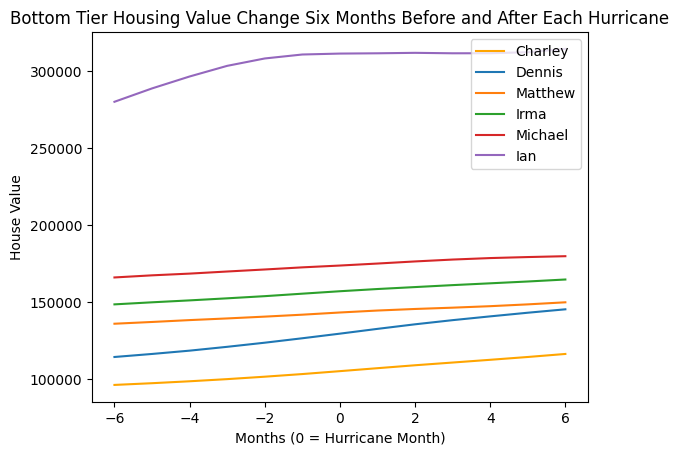

In [21]:
import matplotlib.pyplot as plt
# Visualizing The Value Change of Homes Six Months Before and After Each Hurricane

# to set the plot size
plt.figure()

# using plot method to plot values.
# in plot method we set the label and color of the curve
charley_graph['value'].plot(label='Charley', color='orange')
dennis_graph['value'].plot(label='Dennis')
matthew_graph['value'].plot(label='Matthew')
irma_graph['value'].plot(label='Irma')
michael_graph['value'].plot(label='Michael')
ian_graph['value'].plot(label='Ian')

# adding title to the plot
plt.title('Bottom Tier Housing Value Change Six Months Before and After Each Hurricane')

# adding label to the x-axis
plt.xlabel('Months (0 = Hurricane Month)')

# adding label to the y-axis
plt.ylabel('House Value')

# adding legend to the curve
plt.legend();

### Graphing Middle Tier Housing

In [22]:
#Creating dataframes for each hurricane
#Values are from six months before and after the hurricane
charley_graph = bottom_graph.iloc[49:62]
dennis_graph = bottom_graph.iloc[60:73]
matthew_graph = bottom_graph.iloc[195:208]
irma_graph = bottom_graph.iloc[206:219]
michael_graph = bottom_graph.iloc[219:232]
ian_graph = bottom_graph.iloc[266:279]

In [23]:
def month(df):
    df['month'] = np.repeat(np.arange(-6, 7), 1)
    df.set_index('month', inplace = True)
    return

In [24]:
#applying the function to our dataframes
graph_list = [charley_graph, dennis_graph, matthew_graph, irma_graph, michael_graph, ian_graph]
graph_list = [df.pipe(month) for df in graph_list]

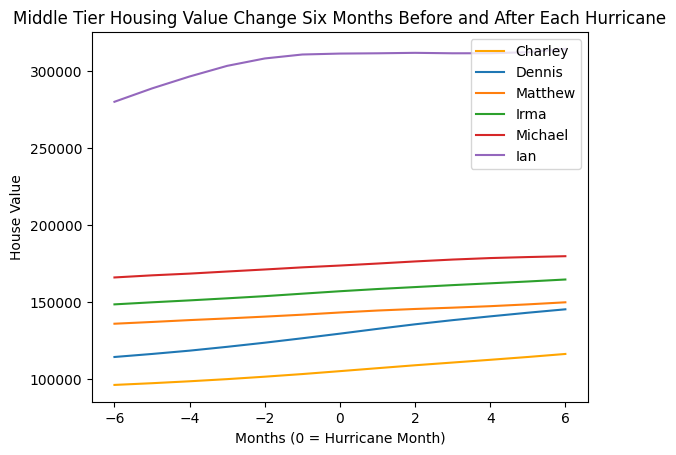

In [25]:
import matplotlib.pyplot as plt
# Visualizing The Value Change of Homes Six Months Before and After Each Hurricane

# to set the plot size
plt.figure()

# using plot method to plot values.
# in plot method we set the label and color of the curve.
charley_graph['value'].plot(label='Charley', color='orange')
dennis_graph['value'].plot(label='Dennis')
matthew_graph['value'].plot(label='Matthew')
irma_graph['value'].plot(label='Irma')
michael_graph['value'].plot(label='Michael')
ian_graph['value'].plot(label='Ian')

# adding title to the plot
plt.title('Middle Tier Housing Value Change Six Months Before and After Each Hurricane')

# adding label to the x-axis
plt.xlabel('Months (0 = Hurricane Month)')

# adding label to the y-axis
plt.ylabel('House Value')

# adding legend to the curve
plt.legend();

### Graphing Top Tier Housing

In [26]:
#Creating dataframes for each hurricane
#Values are from six months before and after the hurricane
charley_graph = bottom_graph.iloc[49:62]
dennis_graph = bottom_graph.iloc[60:73]
matthew_graph = bottom_graph.iloc[195:208]
irma_graph = bottom_graph.iloc[206:219]
michael_graph = bottom_graph.iloc[219:232]
ian_graph = bottom_graph.iloc[266:279]

In [27]:
def month(df):
    df['month'] = np.repeat(np.arange(-6, 7), 1)
    df.set_index('month', inplace = True)
    return

In [28]:
#applying the function to our dataframes
graph_list = [charley_graph, dennis_graph, matthew_graph, irma_graph, michael_graph, ian_graph]
graph_list = [df.pipe(month) for df in graph_list]

In [29]:
graph_list[0]

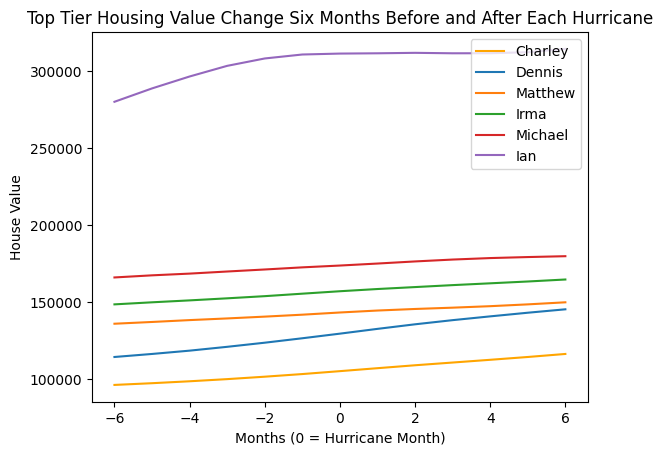

In [30]:
import matplotlib.pyplot as plt
# Visualizing The Value Change of Homes Six Months Before and After Each Hurricane

# to set the plot size
fig= plt.figure()

# using plot method to plot values.
# in plot method we set the label and color of the curve.
charley_graph['value'].plot(label='Charley', color='orange')
dennis_graph['value'].plot(label='Dennis')
matthew_graph['value'].plot(label='Matthew')
irma_graph['value'].plot(label='Irma')
michael_graph['value'].plot(label='Michael')
ian_graph['value'].plot(label='Ian')

# adding title to the plot
plt.title('Top Tier Housing Value Change Six Months Before and After Each Hurricane')

# adding label to the x-axis
plt.xlabel('Months (0 = Hurricane Month)')

# adding label to the y-axis
plt.ylabel('House Value')

# adding legend to the curve
plt.legend();


## Visualizing Wind Speed

As we can see from the box and whisker plot below the largest hurricane was Irma and Ian. The variable of average wind speed is a recording of the average wind speed for the whole day. While other hurricanes may have had significant wind gusts and max speeds, what made hurricanes like Irma and Ian unique devastating was that they were extremely slow moving and stagnant. We can also see from the scatterplots below that each hurricane has a unique path. While coastal cities do tend to take more damage, at times inland regions can also experience severe damage.


In [31]:
hurricane = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/hurricane_visualization.csv')
charley = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/charley_visualization.csv')
ian = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/ian_visualization.csv')
michael = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/michael_visualization.csv')
matthew = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/matthew_visualization.csv')
irma = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/irma_visualization.csv')
dennis = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/dennis_visualization.csv')


### Box and Whisker Plot of Average Wind Speed

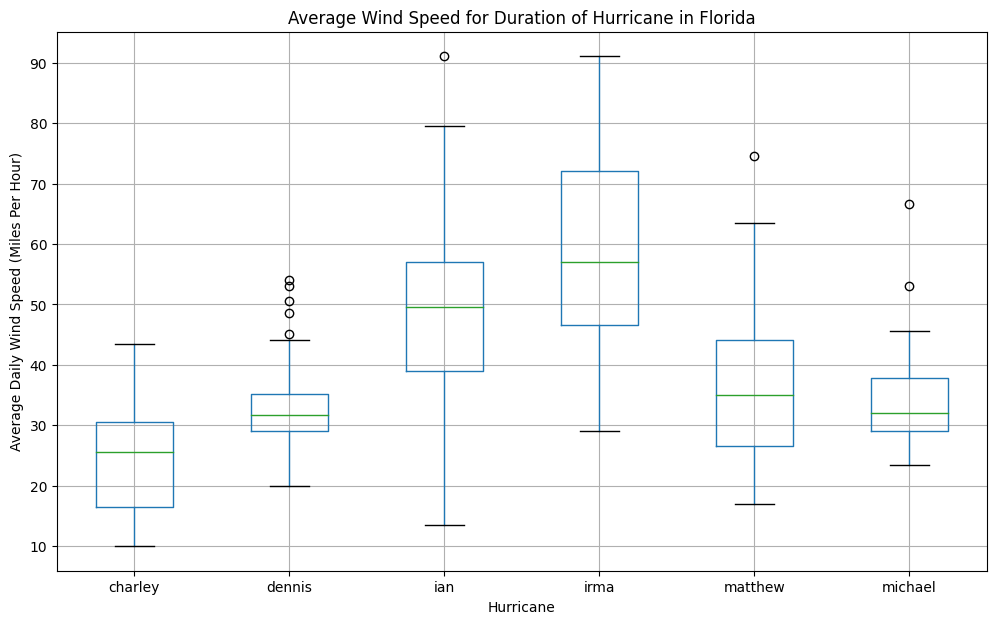

In [32]:
#Generate a box and whiskers plot for all six hurricanes
#creating a dataframe that has just HurricaneName and AWND
hurricane_bw = hurricane[['HurricaneName', 'AWND']]
#pivoting the values
hurricane_bw = hurricane_bw.pivot(columns='HurricaneName', values='AWND')
#plotting
box = hurricane_bw.boxplot(figsize = (12,7,));
box.plot()
#adding title
plt.title('Average Wind Speed for Duration of Hurricane in Florida')
#adding xlabel
plt.xlabel('Hurricane')
#adding ylabel
plt.ylabel('Average Daily Wind Speed (Miles Per Hour)');

In [33]:
#creating a scatterplot function
def scatterplot(df):
    #importing image for background
    img = plt.imread(r"/content/hurricane-impact-on-florida-real-estate/floridamap.jpg")
    fig, ax = plt.subplots()
    ax.imshow(img, extent=[-87, -80, 25, 31])
    #plotting scatter plot
    plt.scatter(x=df['LONGITUDE'], y=df['LATITUDE'], s=50, c=df['WSF2'], cmap='plasma')
    #title
    plt.title('Fastest 2 Minute Wind Gust')
    #xlabel
    plt.xlabel('Longitude')
    #y label
    plt.ylabel('Latitude')
    #legend
    ax.legend(df['HurricaneName'])
    return plt.show()

### Scatterplot of Fastest 2 Minute Wind Gust for Each Hurricane

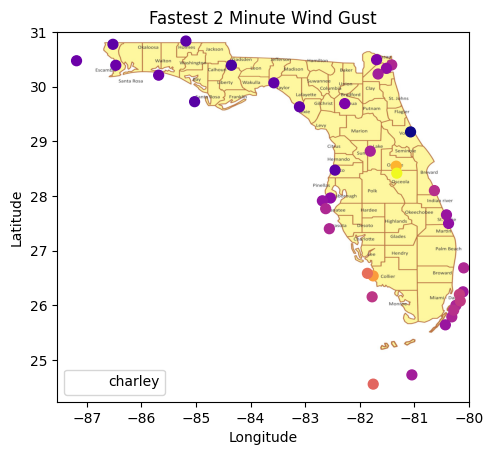

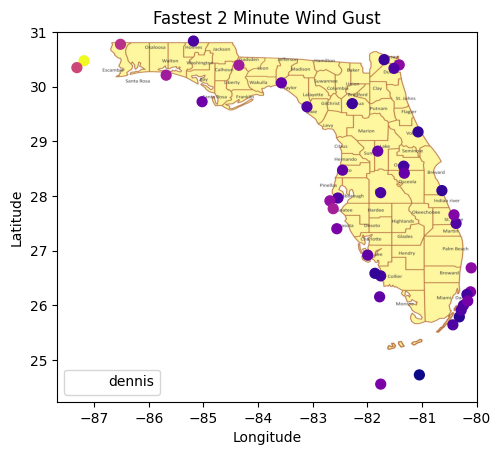

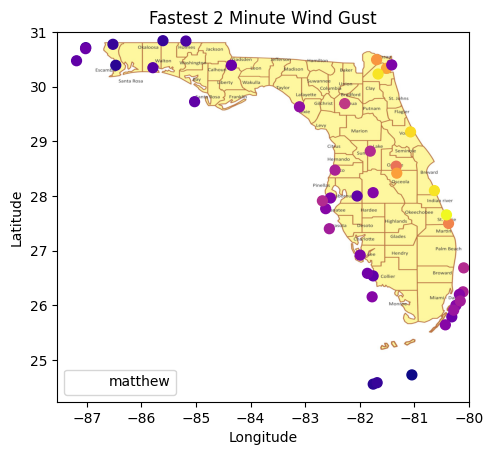

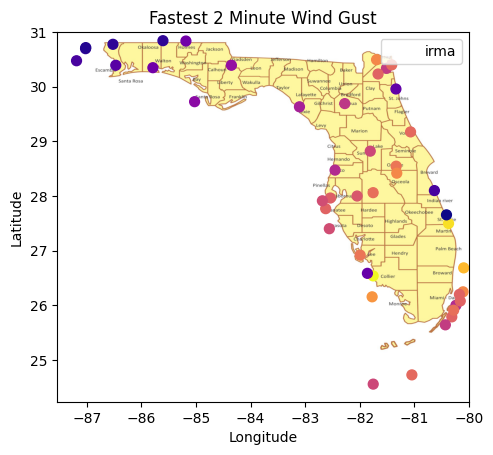

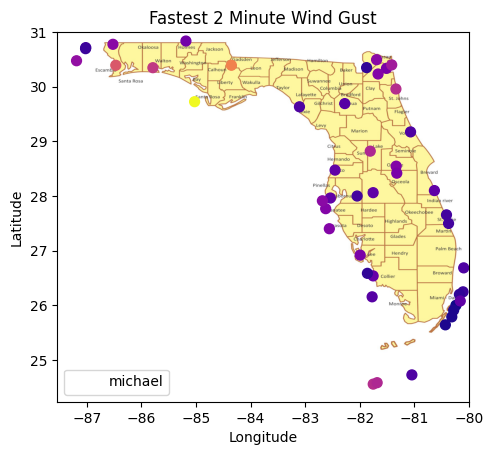

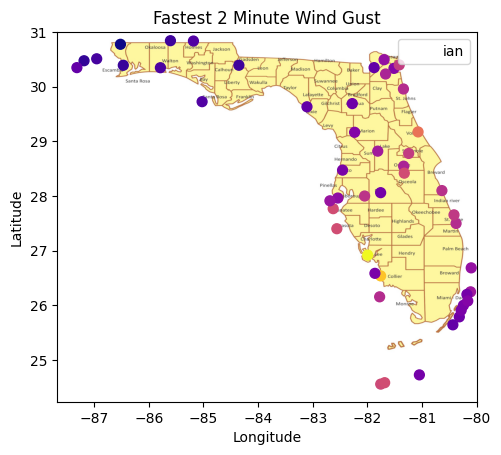

In [34]:
#applying scatterplot function to our hurricanes
scatterplot(charley)
scatterplot(dennis)
scatterplot(matthew)
scatterplot(irma)
scatterplot(michael)
scatterplot(ian)

## Visualizing Feature Relationships

In [35]:
#opening datasets for visualization
bottom_hurricane = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/bottom_hurricane.csv')
middle_hurricane = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/middle_hurricane.csv')
top_hurricane = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/top_hurricane.csv')
all_hurricane = pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/all_hurricane.csv')

### Variable Correlation

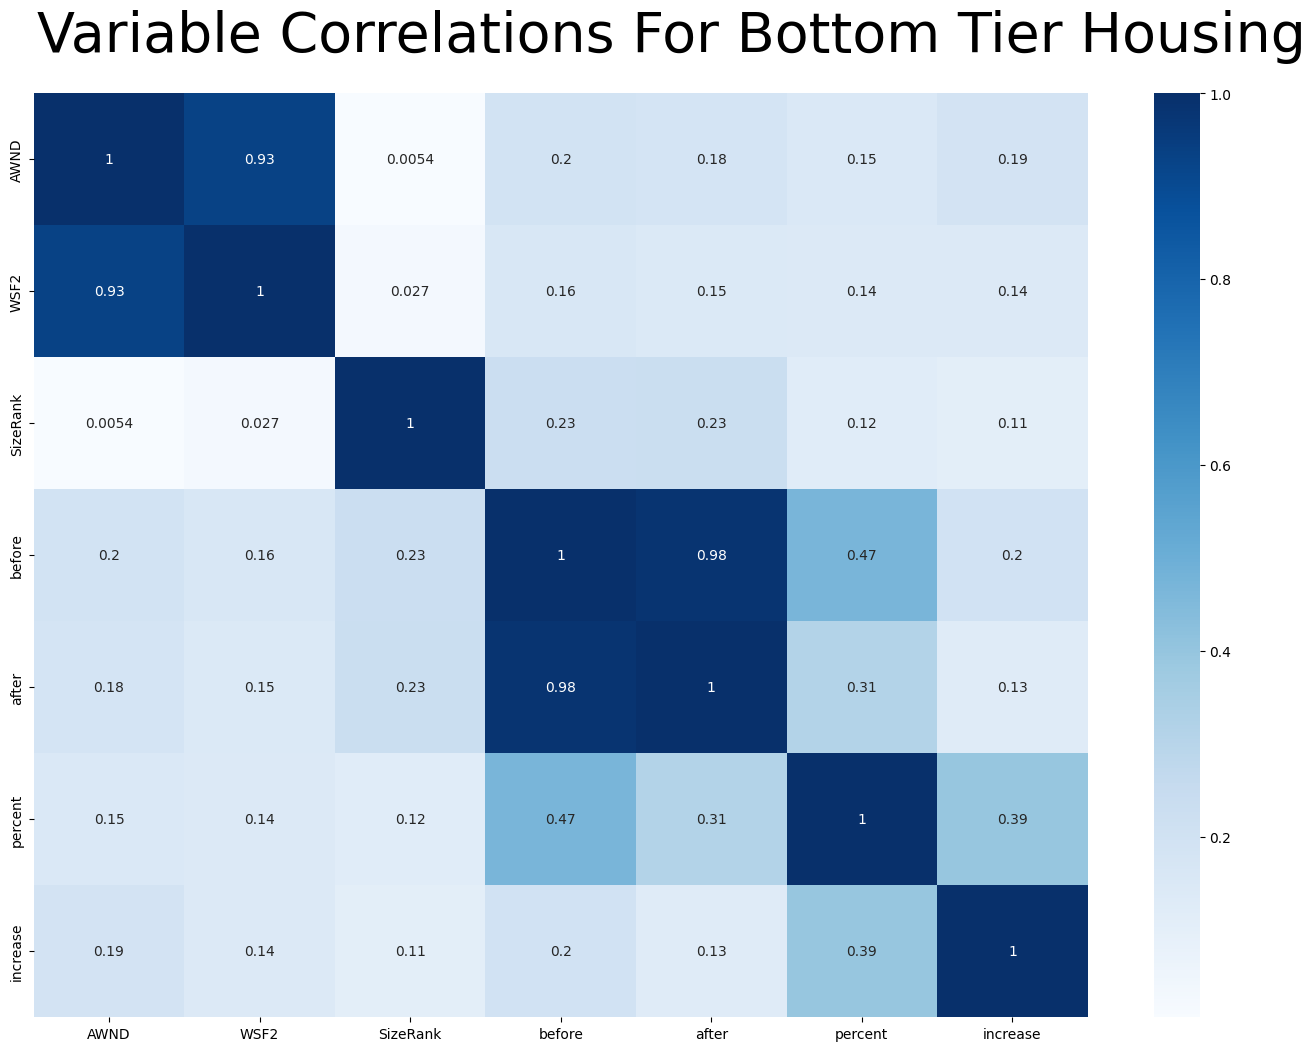

In [36]:
#checking variable correlations for bottom tier housing
#high correlation between AWND and WSF2
#high correlation between before and after
corr = bottom_hurricane.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Variable Correlations For Bottom Tier Housing', fontsize=40, y=.95, fontname='DejaVu Sans')
heatmap = sns.heatmap(corr, cmap='Blues', annot=True)

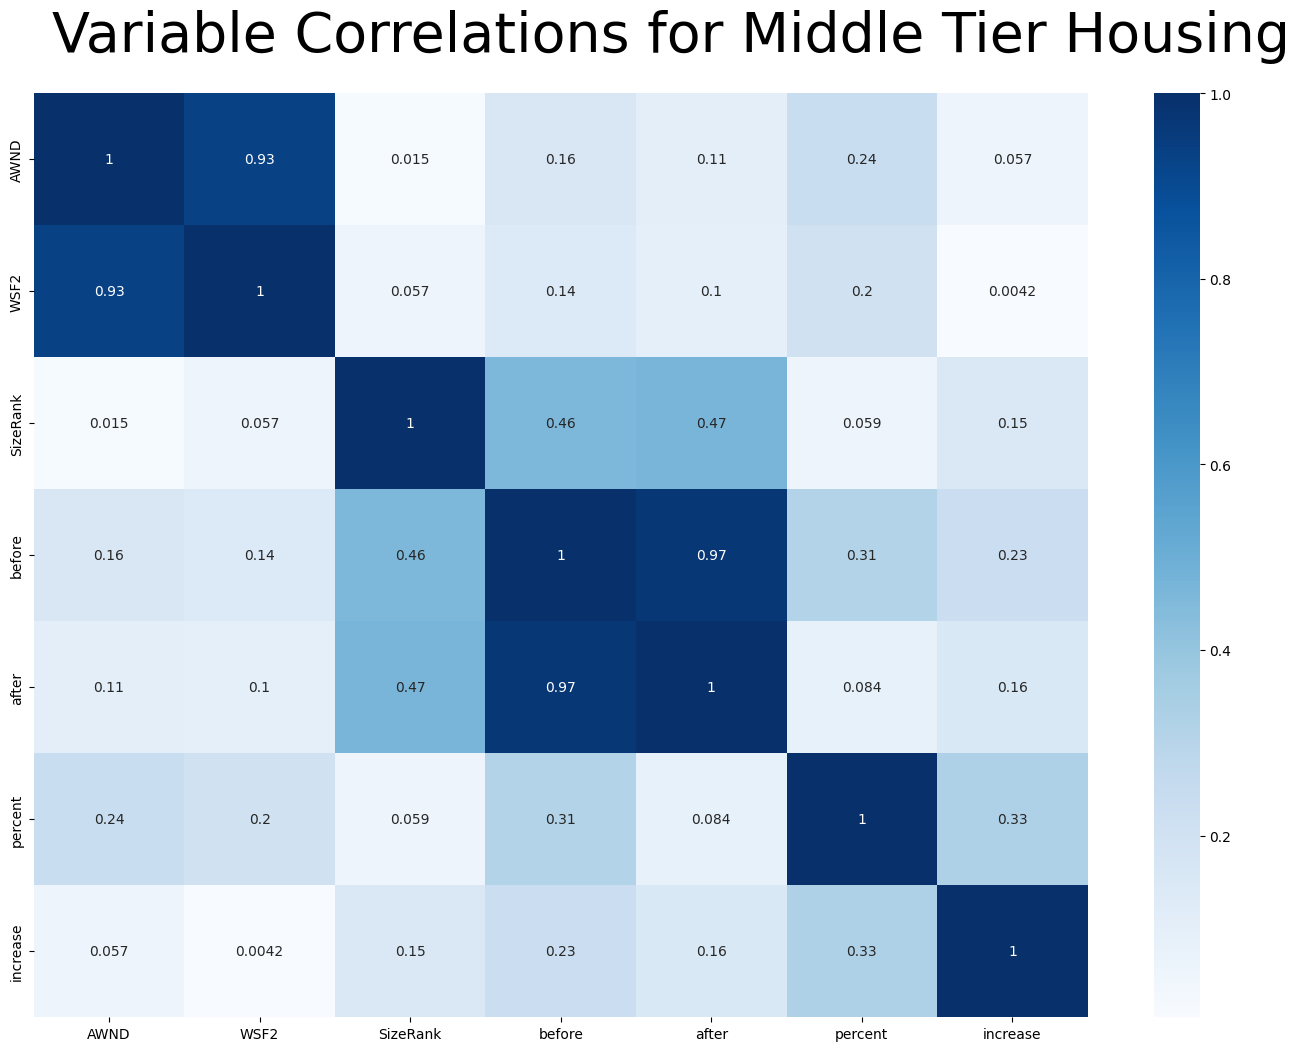

In [37]:
#checking variable correlations for middle tier housing
#high correlation between AWND and WSF2
#high crrelation between before and after
corr = middle_hurricane.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Variable Correlations for Middle Tier Housing', fontsize=40, y=.95, fontname='DejaVu Sans')
heatmap = sns.heatmap(corr, cmap='Blues', annot=True)

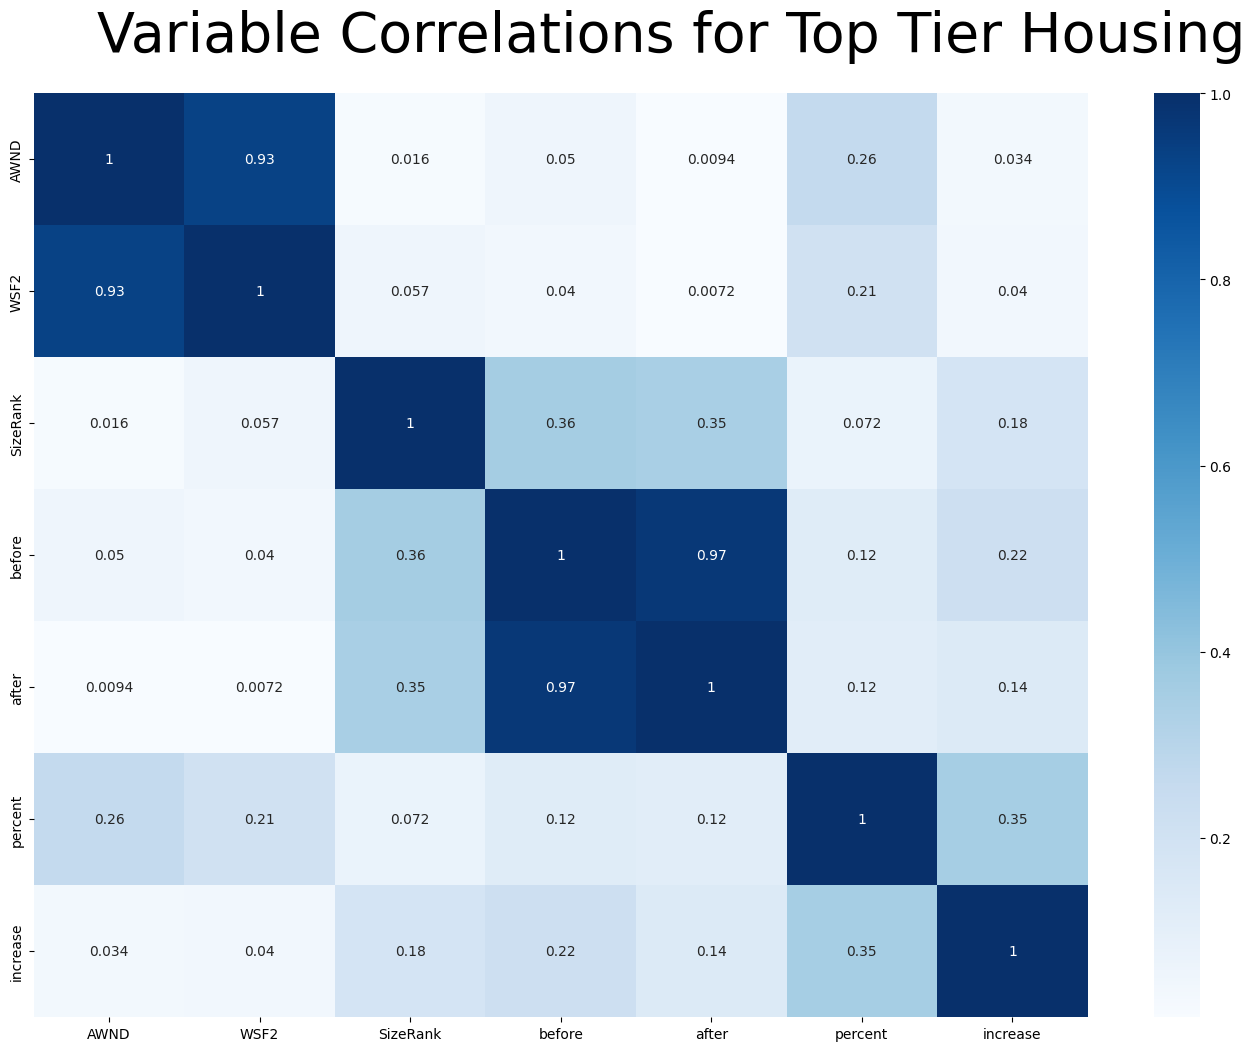

In [38]:
#checking variable correlations for top tier housing
#high correlation between AWND and WSF2
#high crrelation between before and after
corr = top_hurricane.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Variable Correlations for Top Tier Housing', fontsize=40, y=.95, fontname='DejaVu Sans')
heatmap = sns.heatmap(corr, cmap='Blues', annot=True)

### Pairplot

#### Pairplot for Bottom Tier Dataset

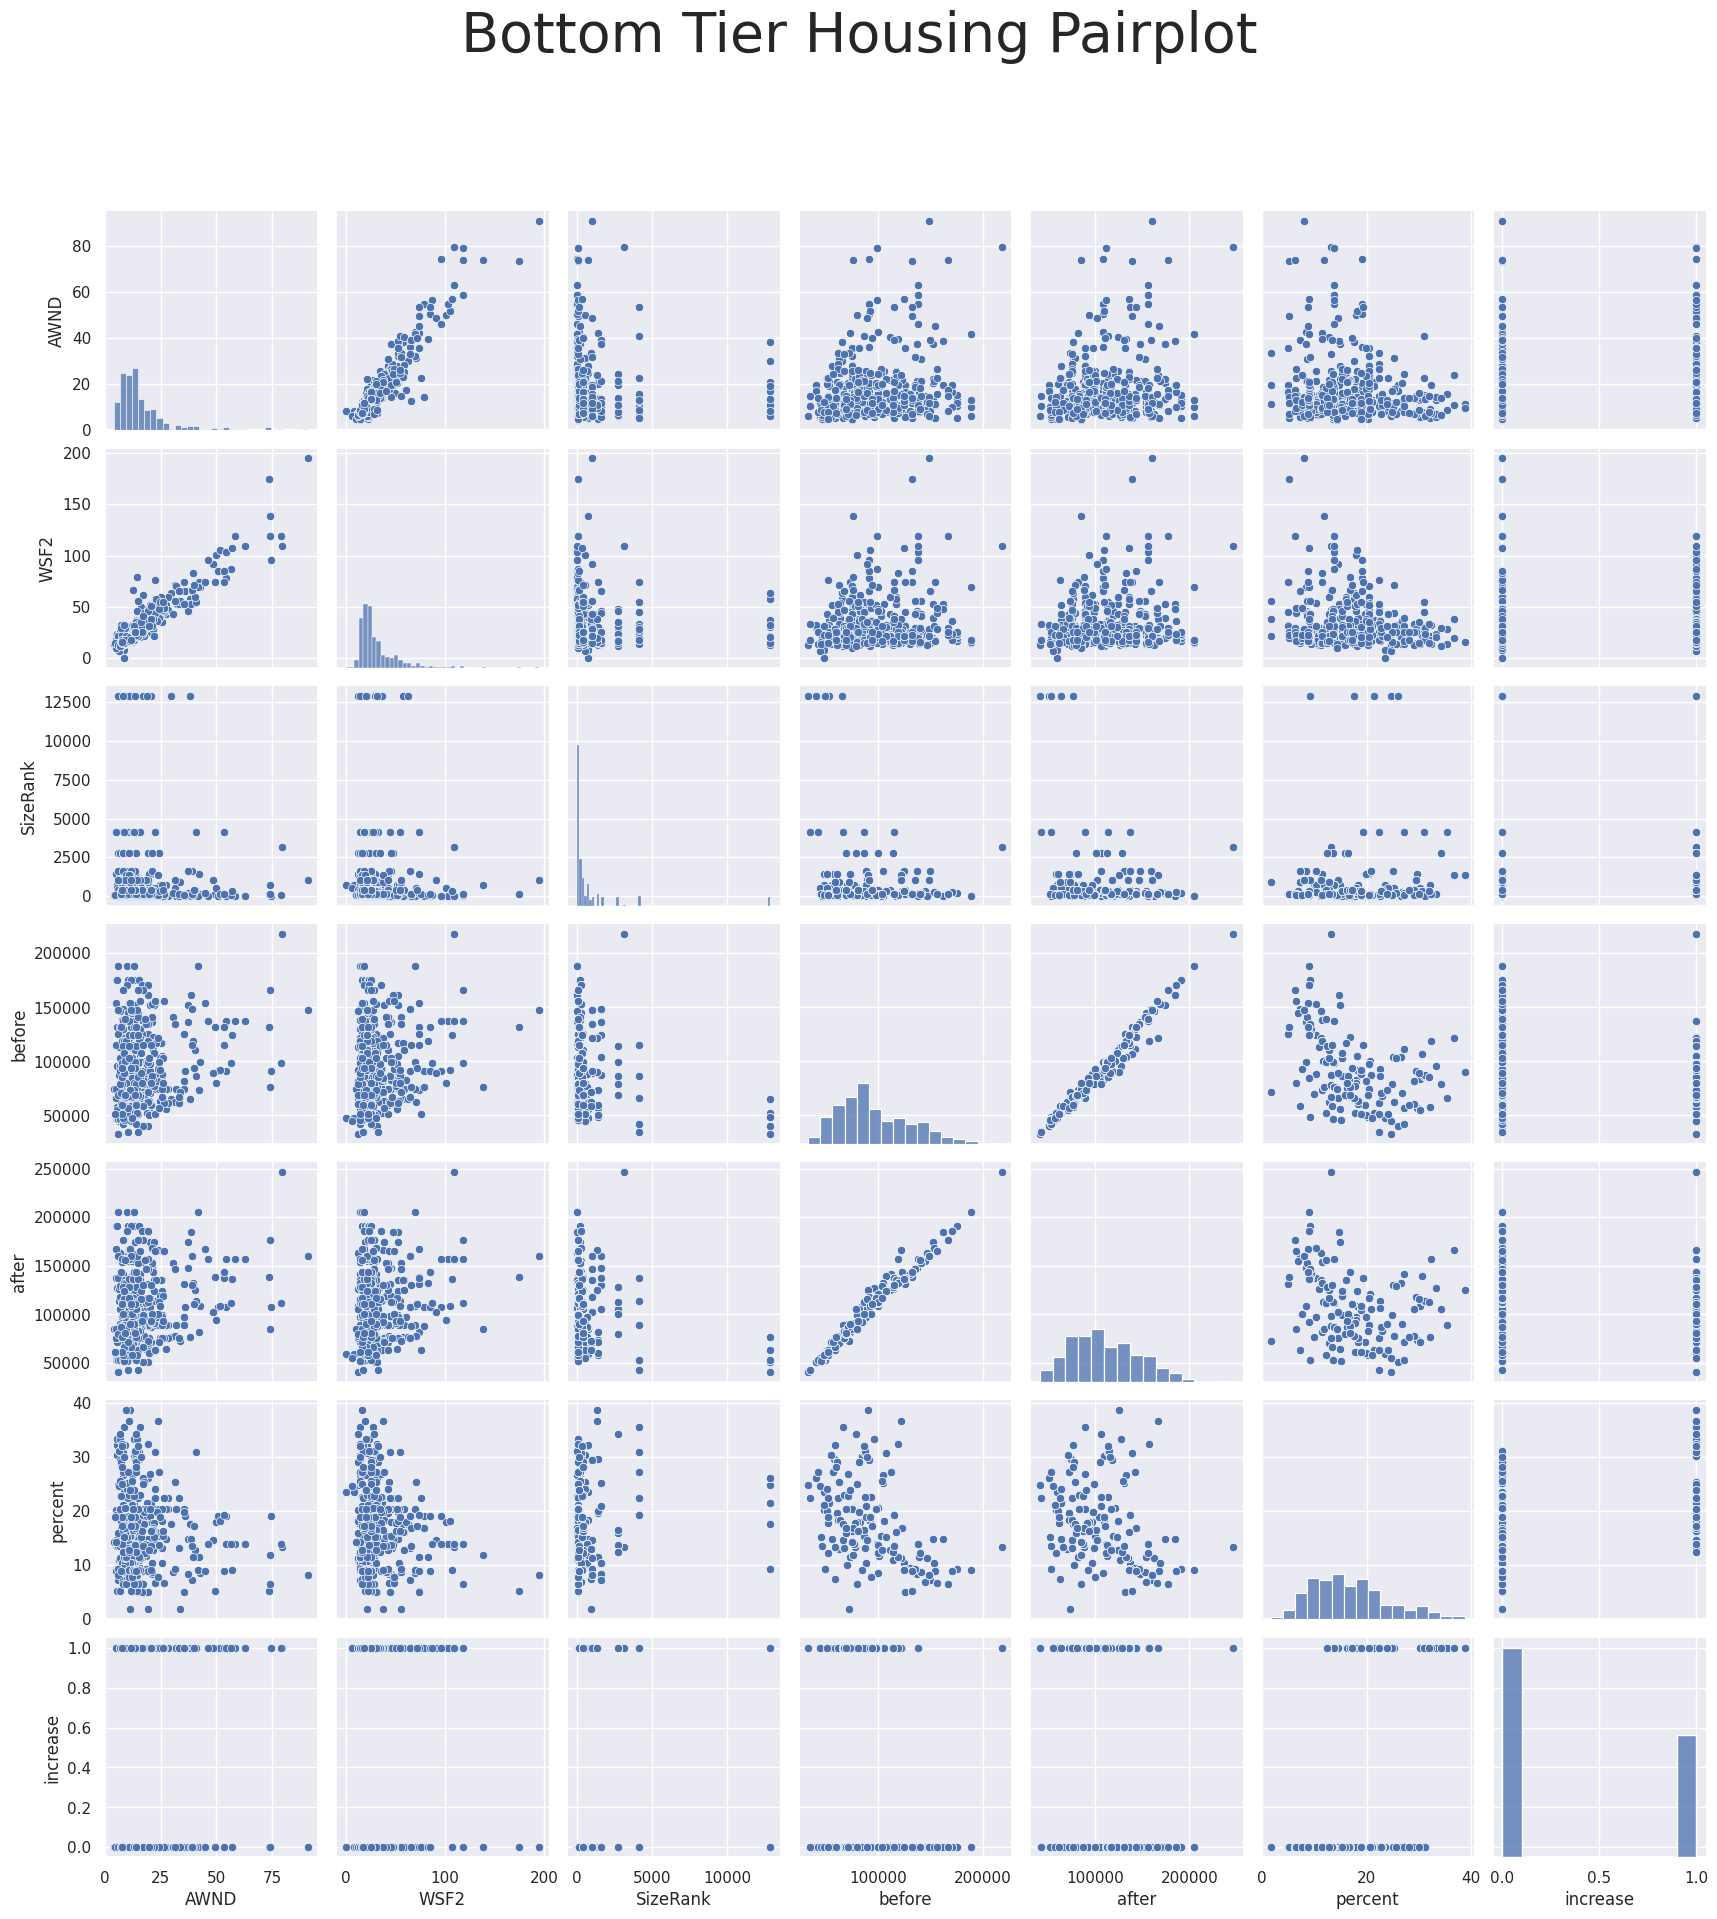

In [39]:
#plotting bottom_hurricane
#long tail on AWND and WSF2
sns.set()
s = sns.pairplot(bottom_hurricane, size = 2.5)
s.fig.suptitle("Bottom Tier Housing Pairplot", y= 1.1, fontsize=40)
plt.show();

#### Pairplot for Middle Tier Dataset

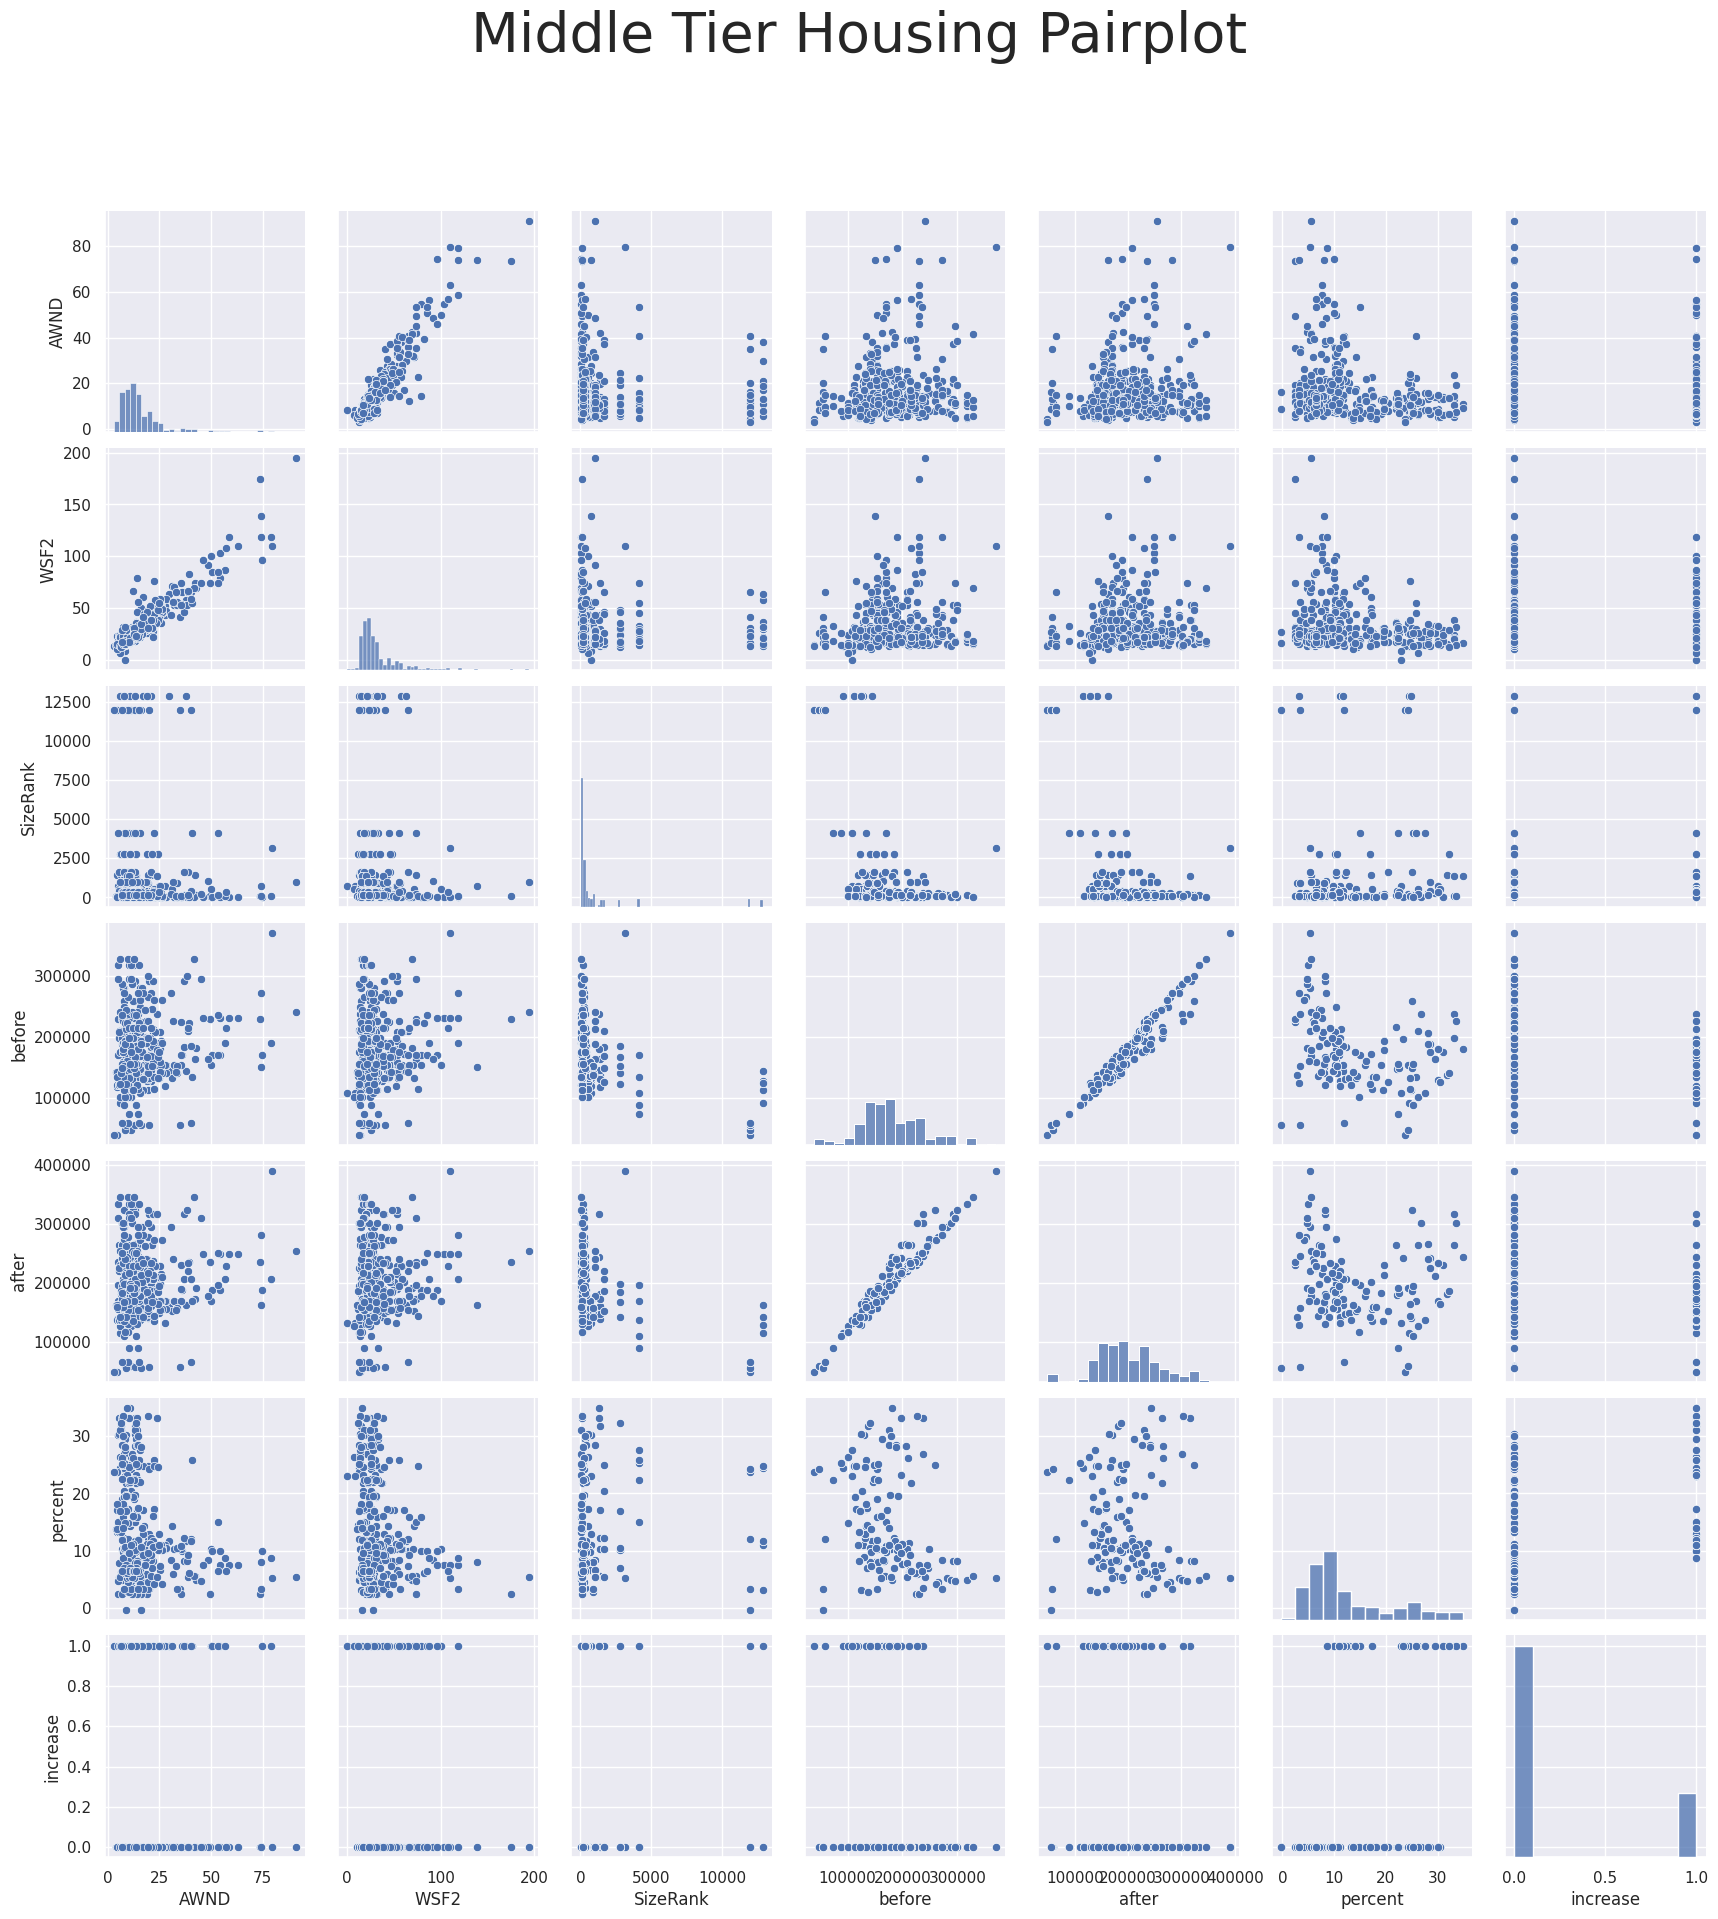

In [40]:
#plotting middle_hurricane
#long tail on AWND and WSF2
sns.set()
s = sns.pairplot(middle_hurricane, size = 2.5)
s.fig.suptitle("Middle Tier Housing Pairplot", y= 1.1, fontsize=40)
plt.show();

#### Pairplot for Top Tier Dataset

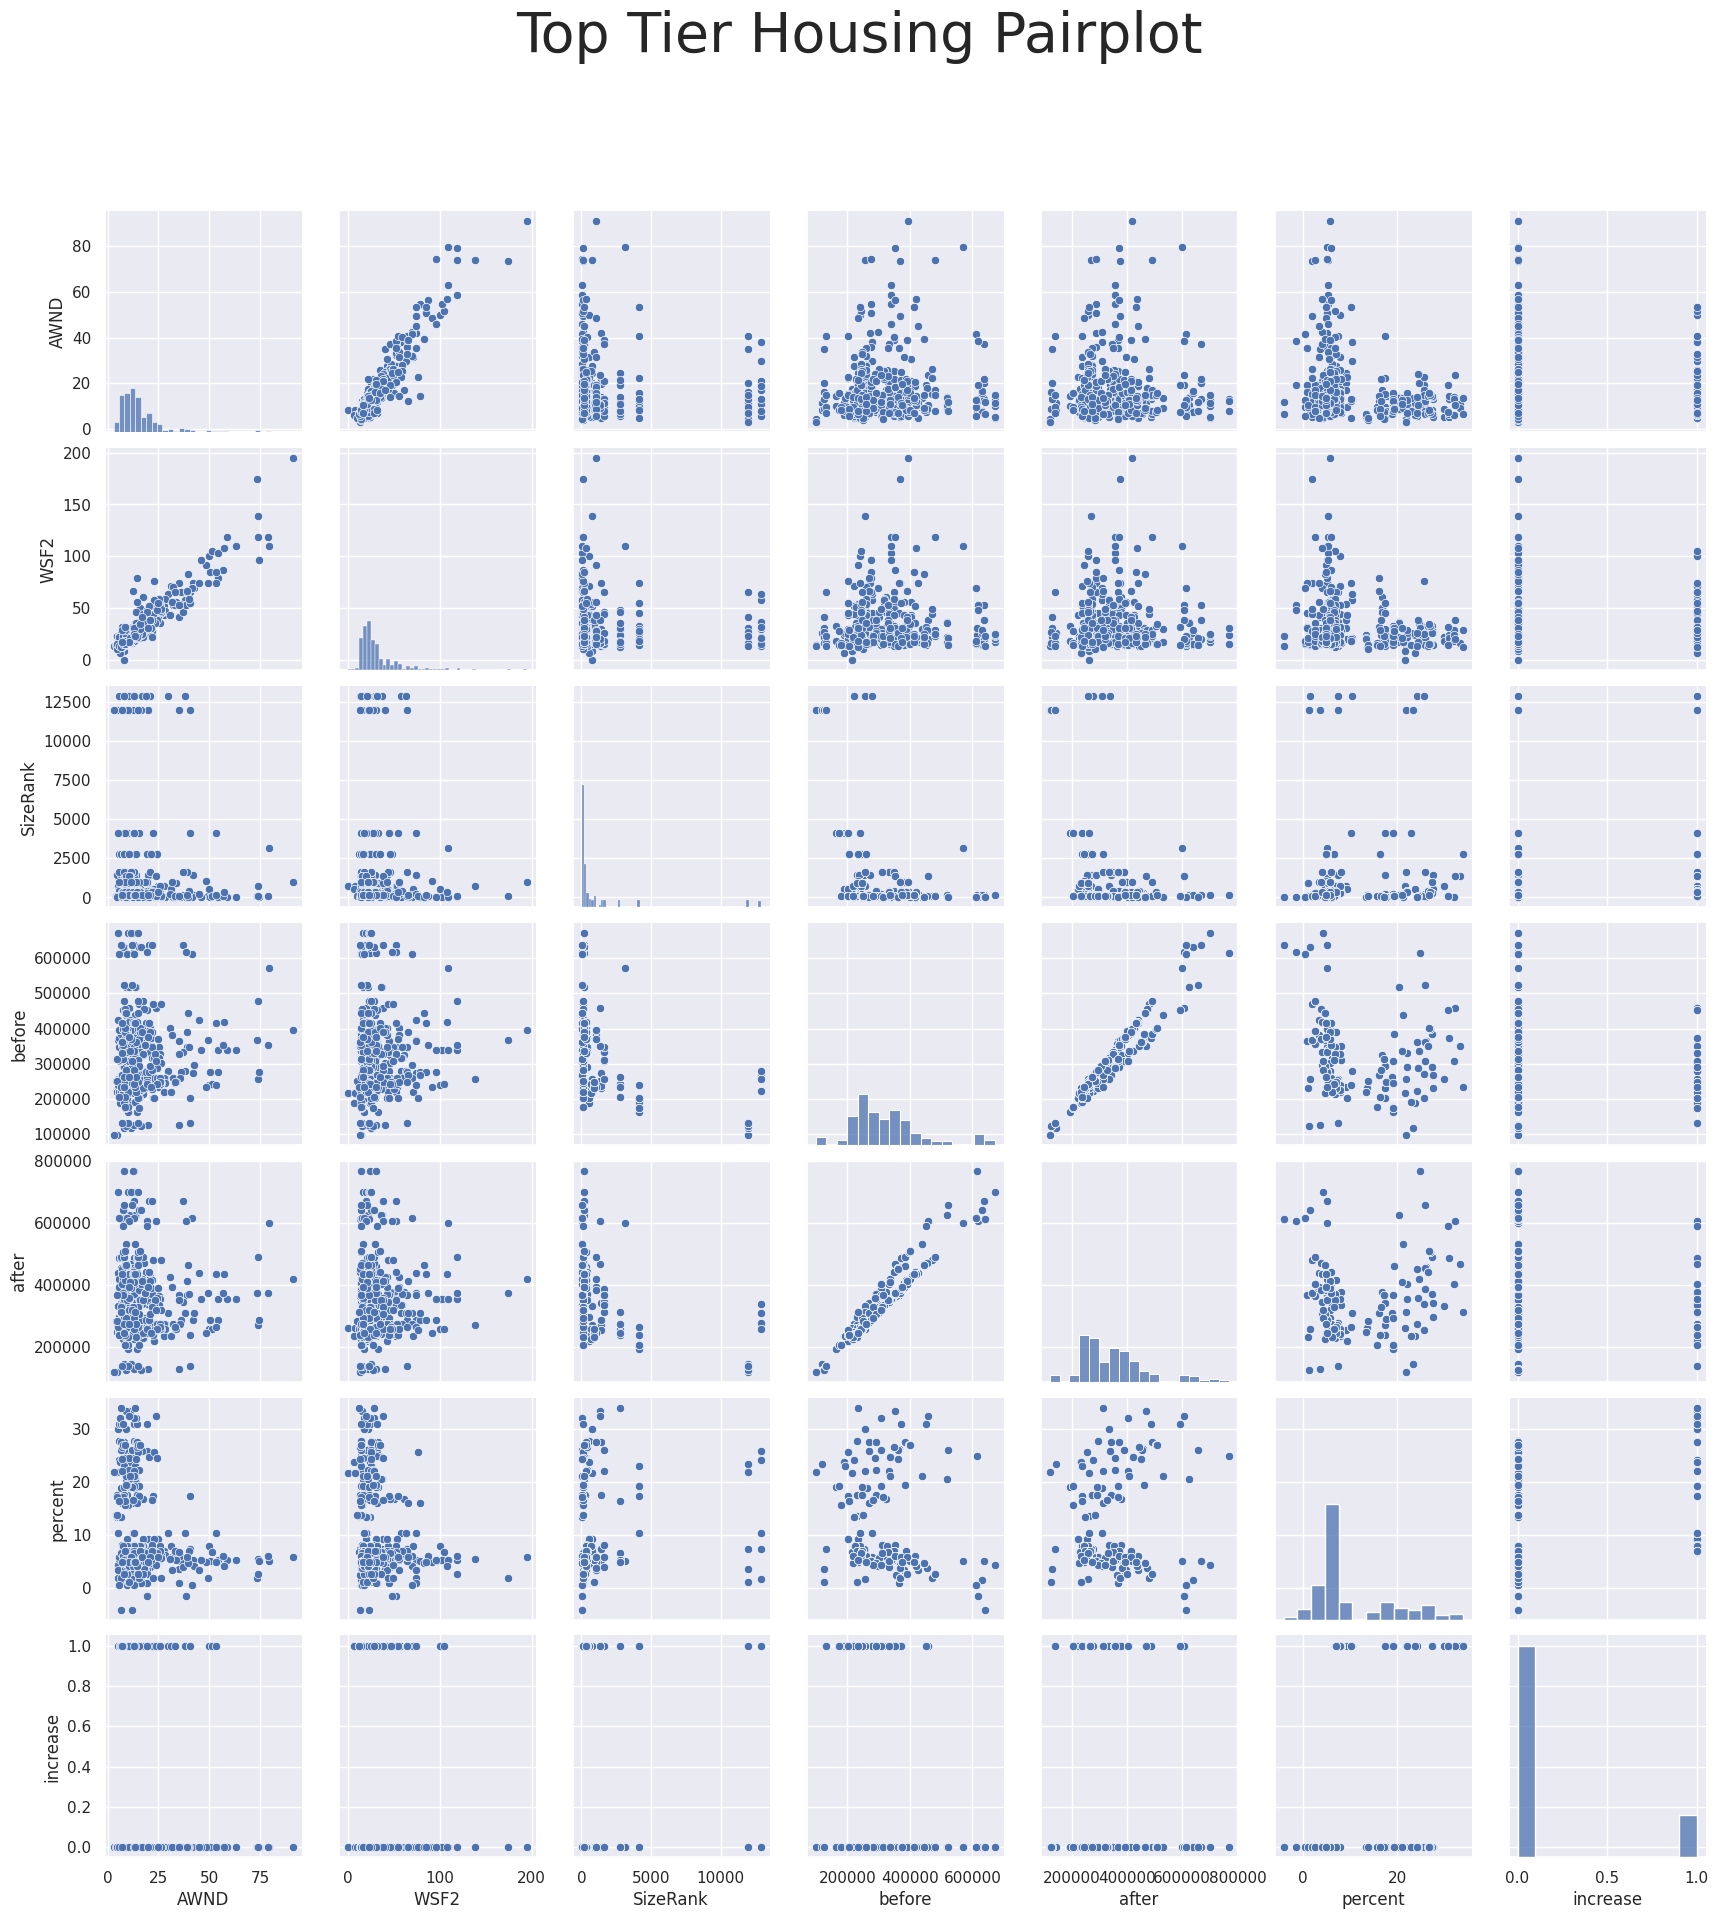

In [41]:
#plotting top_hurricane
#long tail on AWND and WSF2
sns.set()
s = sns.pairplot(top_hurricane, size = 2.5)
s.fig.suptitle("Top Tier Housing Pairplot", y= 1.1, fontsize=40)
plt.show();

# Modeling

Of equal concern to the business problem was the model predicting False Negatives or False Positives. In this situation both are of equal importance to our real estate client. If the model predicts that the home value will not increase but it does (false negative) then our client could lose out on a possible higher return on a home. However, if the model predicts that the home value will increase but it does not (false positive) then our client may have invested money into a home that does not pay off.

For the scope of this project we will be using accuracy and F1 score to assess our model performance. Since we had a class imbalance we could not solely rely on accuracy to communicate model performance. Since, precision and recall were of equal importance for our business problem F1 score was used to assess model performance.

- **Model accuracy** is a machine learning classification model performance metric that takes the ratio of true positives and true negatives to all positives and negative results. It communicates how often our model will correctly predict an outcome out of the total number of predictions made. However, accuracy metrics are not always reliable for imbalance datasets. Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)  

- **Model F1 Score** is a model performance metric that gives equal weight to both the Precision and Recall for measuring performance. F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)    

- **ROC-AUC** The Receiver Operator Characteristic (ROC) curve is used to assess a model’s ability to correctly classify by plotting the true positive rate against the false positive rate. A curve that ‘peaks’ more quickly communicates that there is a good true positive rate and a low false positive rate. The area under the curve (AUC) is derived from ROC and has a baseline chance of 50% accuracy, hence, an AUC closer to 1 signifies a better classification model.

**Works Cited**   
Filho M. How To Get Feature Importance In Logistic Regression. forecastegy.com. Published March 30, 2023. Accessed July 10, 2023. https://forecastegy.com/posts/feature-importance-in-logistic-regression/#feature-importance-in-binary-logistic-regression     
Kumar A. Accuracy, Precision, Recall & F1-Score - Python Examples. Data Analytics. Published October 1, 2021. https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

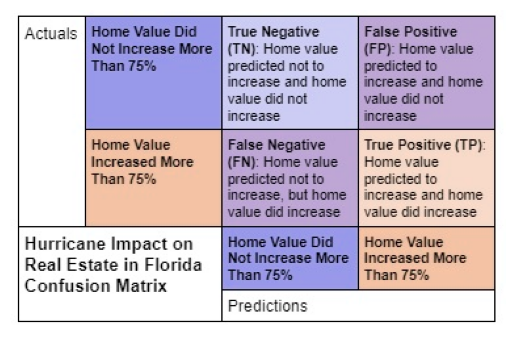

In [42]:
#opening confusion_matrix
confusion_matrix = cv2.imread('/content/hurricane-impact-on-florida-real-estate/Confusion_Matrix.jpg',1)
plt.imshow(confusion_matrix)
plt.axis("off")
plt.show()

In [43]:
#opening datasets for modeling
all_ian =  pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/ian_final.csv')
middle_model =  pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/middle_final.csv')
bottom_model =  pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/bottom_final.csv')
top_model =  pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/top_final.csv')
all_model =  pd.read_csv(r'/content/hurricane-impact-on-florida-real-estate/all_final.csv')

## Baseline Model

### Examining Class Imbalance

In order to know what a good accuracy is for our models, we must know what the majority class percent is. This will tell us if our model performs any better than just selecting the majority class each time. From the count plots below we can see that the average class imbalance is 74%, which makes sense because our cutoff value was the 75th percentile.

|Dataset | Increase | No Increase | No Increase as Percent |
|---|---|---|---|
|Bottom Tier| 45 | 96| 68% |
|Middle Tier| 33 | 106 | 76% |
|Top Tier| 28 | 114 | 80% |
|All| 89 | 255 | 74% |

#### Bottom Tier Class Imabalance

0    96
1    45
Name: increase, dtype: int64
majority percent is 68.08510638297872 %


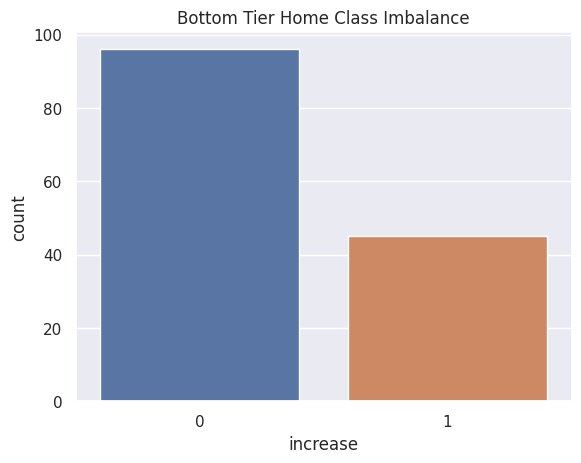

In [44]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=bottom_model).set(title='Bottom Tier Home Class Imbalance')
print(bottom_model['increase'].value_counts())
#checking ratio to see what accuracy is like
percent_bottom = (len(bottom_model['increase']) - bottom_model['increase'].sum())/(len(bottom_model['increase']) - bottom_model['increase'].sum()+bottom_model['increase'].sum())*100
print("majority percent is {}".format(percent_bottom),"%")


#### Middle Tier Class Imbalance

0    106
1     33
Name: increase, dtype: int64
majority percent is 76.2589928057554 %


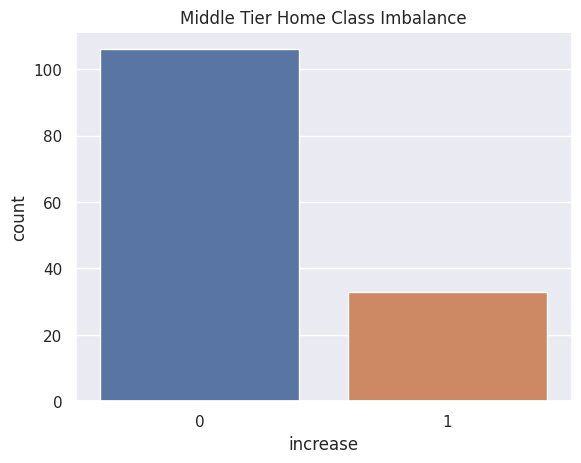

In [45]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=middle_model).set(title='Middle Tier Home Class Imbalance')
print(middle_model['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(middle_model['increase']) - middle_model['increase'].sum())/(len(middle_model['increase']) - middle_model['increase'].sum()+middle_model['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

#### Top Tier Class Imbalance

0    114
1     28
Name: increase, dtype: int64
majority percent is 80.28169014084507 %


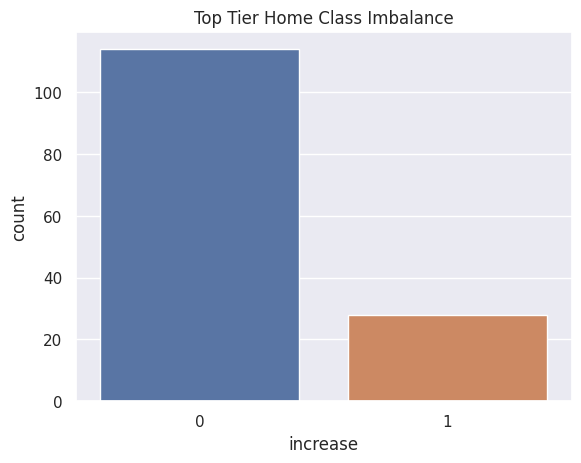

In [46]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=top_model).set(title='Top Tier Home Class Imbalance')
print(top_model['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(top_model['increase']) - top_model['increase'].sum())/(len(top_model['increase']) - top_model['increase'].sum()+top_model['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### All Homes Class Imbalance

0    258
1     86
Name: increase, dtype: int64
majority percent is 75.0 %


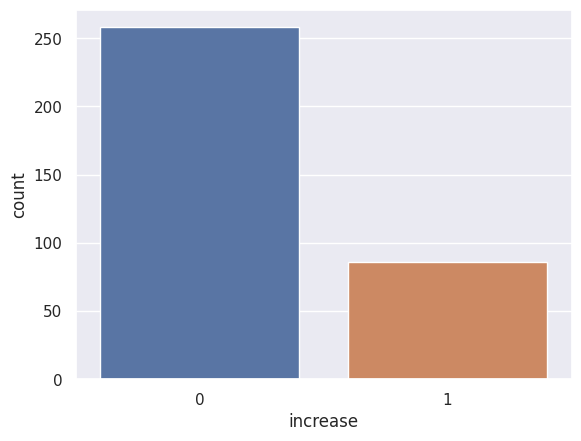

In [47]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=all_model);
print(all_model['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_model['increase']) - all_model['increase'].sum())/(len(all_model['increase']) - all_model['increase'].sum()+all_model['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

## Logistic Regresion

We chose to use a logistic regression model because this is a classification issue and this model works well with categorical data. The model had a default penalty of L2.

A logistic regression model was iterated through with our scaled data. We removed collinear variables and used SMOTE to adjust for the class imbalance. The logistic regression model that performed the best was our SMOTE model with no colinear features and had an accuracy of 0.74 which was slightly better than our baseline accuracy of 0.68 and an F1 score of 0.68.

In [48]:
#establishing model
logreg = LogisticRegression(random_state=56)

## Model 1: Bottom Tier Housing

We will use the bottom tier housing for modeling since it has the best class imbalance.

### Selecting Our Target Variable and Features
Our target variable is increase and for our first iteration of modeling we will use all the available features.

In [49]:
#y is prediction variable
#X is features
y = bottom_model['increase']
X = bottom_model.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split
In order to know how well our model performs we need to test it on data it has not seen. We will use a train/test split to save 30% of our dataset for testing the model.

In [50]:
#performing train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

Currently our dataset contains features that are measured in various way (price, speed, size), in order for our machine learning models to interpret these features they need to be on the same scale, so we will perform scaling.

In [51]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Training Data

Currently, this model is performing as well as the baseline model.

In [52]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [53]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.684


In [54]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.311


### Testing Data

The accuracy is slightly better than the baseline model and of 43 predictions 9 were false negatives and 2 were false positives. The AUC value is good and shows that the model is classifying correctly. The most important features were before and AWND.

In [55]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [56]:
#Printing Accuracy
accuracy_1 = accuracy_score(y_test, y_pred_test)
print(accuracy_1)

0.7441860465116279


In [57]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_1 = f1_score(y_test, y_pred_test)
print(F1_1)

0.35294117647058826


In [58]:
#initiating dictionary to keep model accuracy and F1 score
model_dict = {}
#recording baseline model accuracy
model_dict['Baseline Accuracy'] = percent_bottom
#recording model 1 values
model_dict['LGRModel1_Accuracy'] = accuracy_1
model_dict['LGRModel1_F1'] = F1_1
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826}

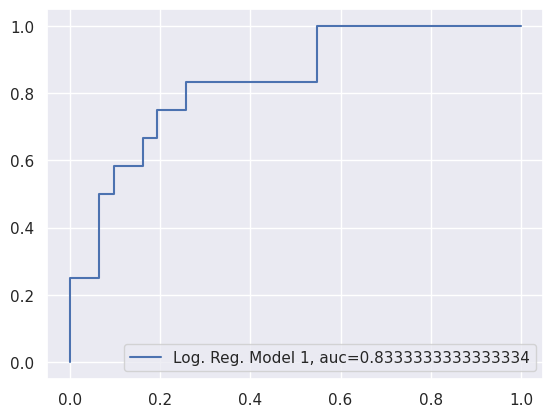

In [59]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

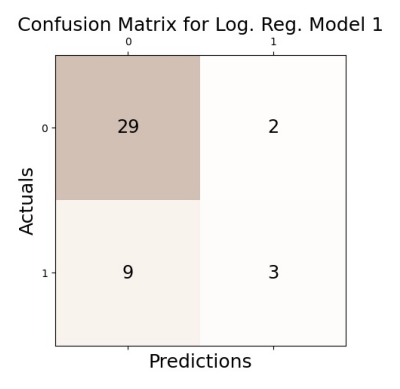

In [60]:
#opening confusion_matrix for model 1
confusion_matrix1 = cv2.imread('/content/hurricane-impact-on-florida-real-estate/cmmodel1.jpg',1)
plt.imshow(confusion_matrix1)
plt.axis("off")
plt.show()

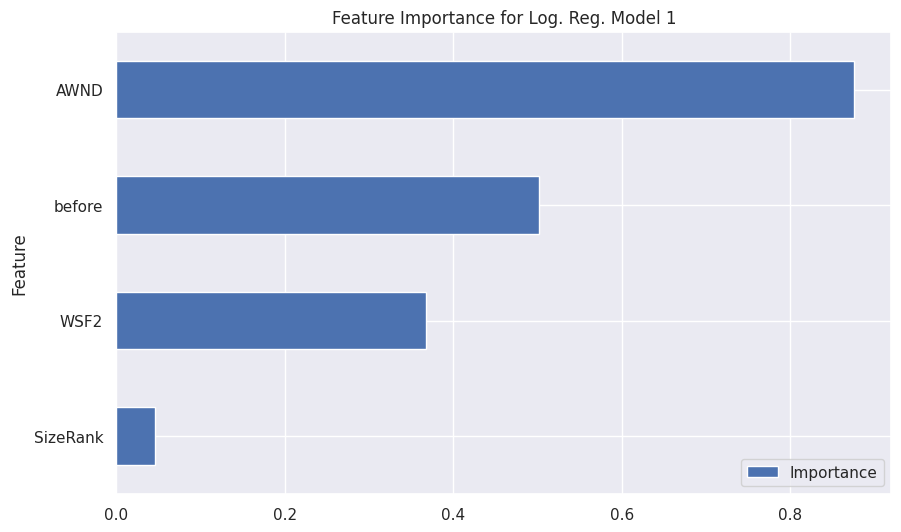

In [61]:
#checking out feature importance
#initiating model
model = LogisticRegression()
#fitting model
model.fit(X_train, y_train)
#getting coefficients
coefficients = model.coef_[0]
#plotting
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', title='Feature Importance for Log. Reg. Model 1', kind='barh', figsize=(10, 6));

## Model 2: Bottom Tier Housing Without Colinear Variables

We will use the bottom tier housing for modeling since it has the best class imbalance.

### Selecting Our Target Variable and Features
Our target variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND.

In [62]:
#y is prediction variable
#X is features
y = bottom_model['increase']
X = bottom_model.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [63]:
#performing train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [64]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Training Data

The performance of this model is not better than the baseline model.

In [65]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [66]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.684


In [67]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.311


### Testing Data

Testing this model we do get better slightly better accuracy than before, meaning that dropping colinear features is effective in improving model performance. And we had one less false positive.

In [68]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [69]:
#Printing Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_test)
print(accuracy_2)

0.7674418604651163


In [70]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_2 = f1_score(y_test, y_pred_test)
print(F1_2)

0.375


### Saving to Dictionary

In [71]:
#adding to model dictionary
model_dict['LGRModel2_Accuracy'] = accuracy_2
model_dict['LGRModel2_F1'] = F1_2
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375}

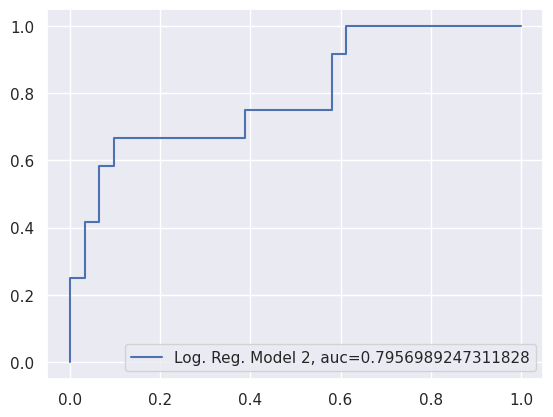

In [72]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 2, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Confusion Matrix

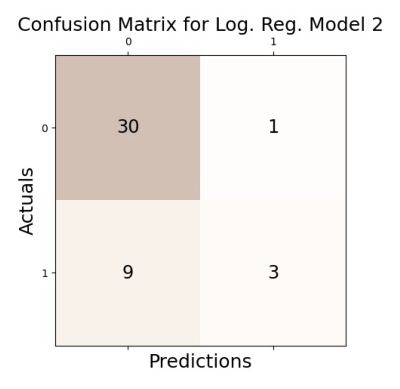

In [73]:
#opening confusion_matrix for model 2
confusion_matrix2 = cv2.imread('/content/hurricane-impact-on-florida-real-estate/cmmodel2.jpg',1)
plt.imshow(confusion_matrix2)
plt.axis("off")
plt.show()

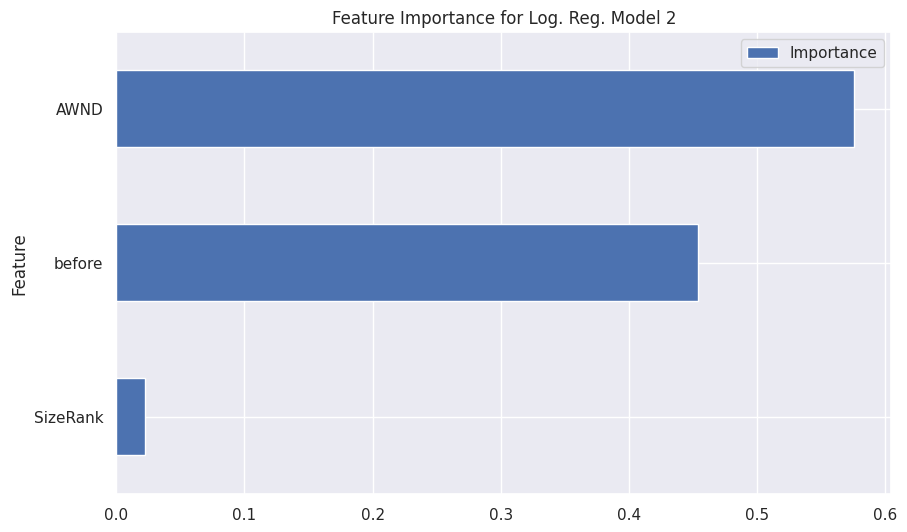

In [74]:
#initiating model
model = LogisticRegression()
#fitting model
model.fit(X_train, y_train)
#getting coefficients
coefficients = model.coef_[0]
#plotting
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title= 'Feature Importance for Log. Reg. Model 2', figsize=(10, 6));

## Model 3: Bottom Tier Housing with Synthetic Minority Oversampling Technique (SMOTE)

Due to the class imbalance in our dataset SMOTE may be effective in improving our model performance. SMOTE can be used to increase the number of cases in our dataset in a balanced way.

In [75]:
#y is prediction variable
#X is features
y = bottom_model['increase']
X = bottom_model.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'WSF2'], axis=1)

### Train/Test Split

In [76]:
#performing train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [77]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### SMOTE

In [78]:
# Create instance of smotec
from imblearn.over_sampling import SMOTE,SMOTENC
# set sampling_strategy to 0.8 to avoid oversampling
smote = SMOTE(sampling_strategy=0.8, random_state=56)

In [79]:
# Create resampled version of the train dataset
SMOTE_X_train, SMOTE_y_train = smote.fit_resample(X_train, y_train)
# Create resampled version of the test dataset
SMOTE_X_test, SMOTE_y_test = smote.fit_resample(X_test, y_test)

In [80]:
#before smote
print('Before Smote\n', y_train.value_counts())

#after smote
print('\nAfter Smote\n', SMOTE_y_train.value_counts())

Before Smote
 0    65
1    33
Name: increase, dtype: int64

After Smote
 0    65
1    52
Name: increase, dtype: int64


### Training Data

Our accuracy is worse than the baseline and previous models, but the F1 score is improving.

In [81]:
#fitting the model unto our training data
logreg.fit(SMOTE_X_train, SMOTE_y_train)
y_pred_train = logreg.predict(SMOTE_X_train)

#### Checking Metrics

In [82]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(SMOTE_y_train, y_pred_train))

Accuracy: 0.641


In [83]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(SMOTE_y_train, y_pred_train))

F1 Score: 0.553


### Testing Data
The model accuracy on the testing data is better than the baseline, but slightly worse than the previous model. However, the F1 score did improve

In [84]:
#fitting the model unto our test data
logreg.fit(SMOTE_X_test, SMOTE_y_test)
y_pred_test = logreg.predict(SMOTE_X_test)

#### Checking Metrics

In [85]:
#Printing Accuracy
accuracy_3 = accuracy_score(SMOTE_y_test, y_pred_test)
print(accuracy_3)

0.7454545454545455


In [86]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_3 = f1_score(SMOTE_y_test, y_pred_test)
print(F1_3)

0.6818181818181818


In [87]:
#adding metrics to dictionary
model_dict['LGRModel3_Accuracy'] = accuracy_3
model_dict['LGRModel3_F1'] = F1_3
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818}

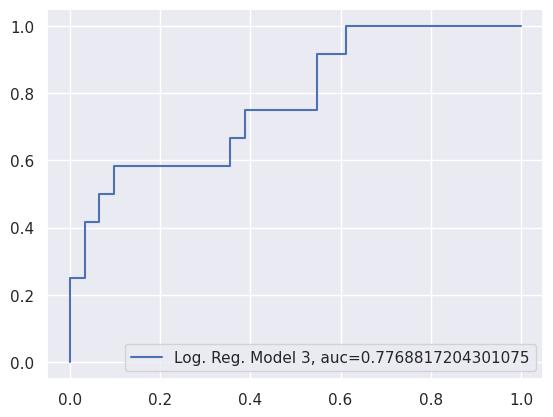

In [88]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 3, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Confusion Matrix

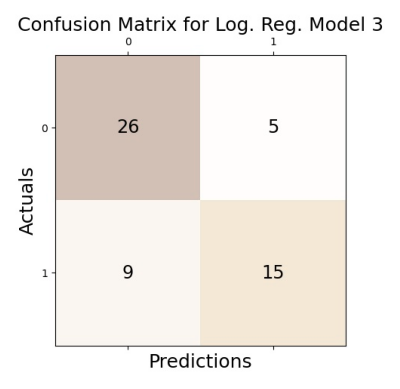

In [89]:
#opening confusion_matrix for model 3
confusion_matrix3 = cv2.imread('/content/hurricane-impact-on-florida-real-estate/cmmodel3.jpg',1)
plt.imshow(confusion_matrix3)
plt.axis("off")
plt.show()

### Feature Importance

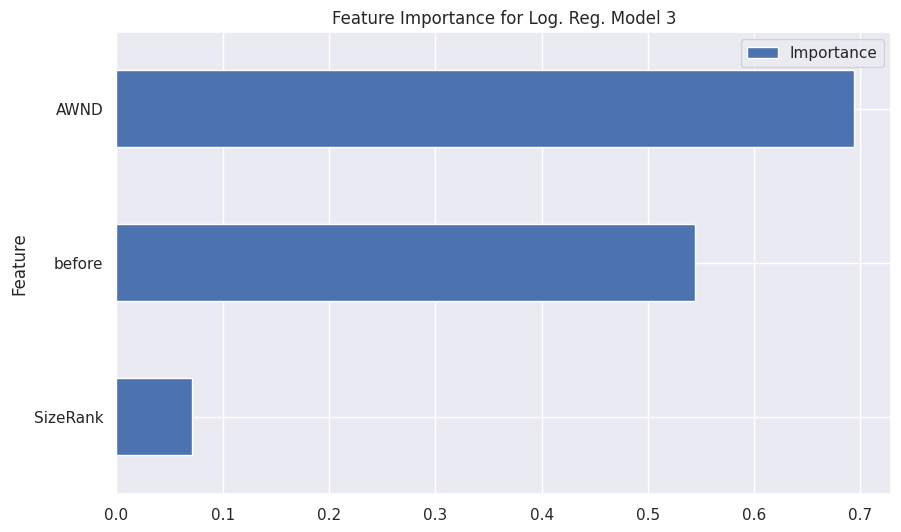

In [90]:
#initiating model
model = LogisticRegression()
#fitting model
model.fit(SMOTE_X_train, SMOTE_y_train)
#getting coefficients
coefficients = model.coef_[0]
#plotting feature_importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title= 'Feature Importance for Log. Reg. Model 3', figsize=(10, 6));

## XGBoost

In [91]:
#initiating model
xgb = XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features

Let's first run the model with all features.

In [92]:
#y is prediction variable
#X is features
y_boost = bottom_model['increase']
X_boost = bottom_model.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split

In [93]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

Using XG Boost we get perfect accuracy.

In [94]:
#fitting the model
xgb.fit(XG_X_train, XG_y_train);

In [95]:
#getting predictions
y_pred_train = xgb.predict(XG_X_train)

In [96]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [97]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


### Testing Data

In [98]:
#fitting the model
xgb.fit(XG_X_test, XG_y_test);

In [99]:
#getting predictions
y_pred_test = xgb.predict(XG_X_test)

In [100]:
#Printing Accuracy
accuracy_XG1 = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XG1)

1.0


In [101]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XG1 = f1_score(XG_y_test, y_pred_test)
print(F1_XG1)

1.0


In [102]:
#adding values to dictionary
model_dict['XGBoost_Accuracy'] = accuracy_XG1
model_dict['XGBoost_F1'] = F1_XG1
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0}

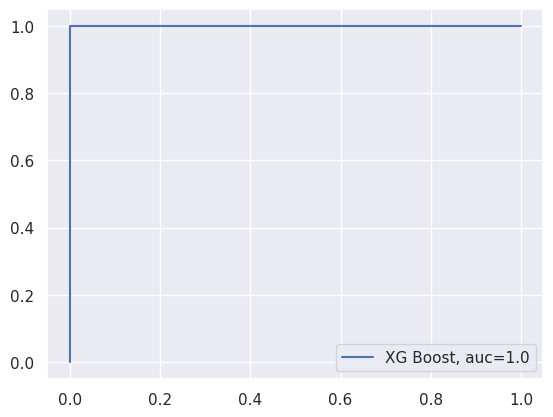

In [103]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(XG_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(XG_y_test,  y_pred_prob)
auc = metrics.roc_auc_score(XG_y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="XG Boost, auc="+str(auc))
plt.legend(loc=4)
plt.show()

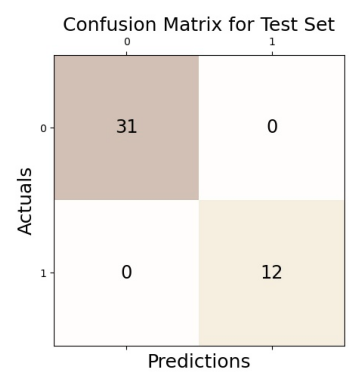

In [104]:
#opening confusion_matrix for XG Boost
confusion_matrix_test = cv2.imread('/content/hurricane-impact-on-florida-real-estate/cmmodeltest.jpg',1)
plt.imshow(confusion_matrix_test)
plt.axis("off")
plt.show()

### Feature Importance using SHAP (SHapley Additive exPlanations)

SHAP is used to explain the output of machine learning models. Using a beeswarm plot can reveal the importance of features and their relationship with the predicted outcome.

shap_values: is the average contribution of each of the features to the prediction for each sample based on alll the possible features.

From the plot below we can interpret that:
- larger SizeRank values have a higher impact on feature value     
- smaller before values have a higher impact on feature value      
- higher WSF2 and AWND values have higher impact on feature value      

Works Cited   
Classification Feature Selection : SHAP Tutorial. kaggle.com. Accessed July 6, 2023. https://www.kaggle.com/code/ritzig/classification-feature-selection-shap-tutorial#SHAP


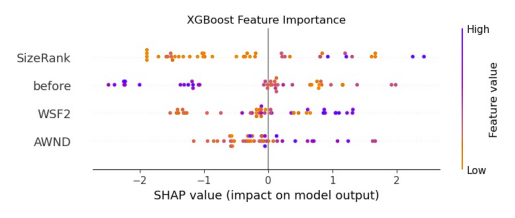

In [105]:
#opening SHAP beeswarm plot
SHAP = cv2.imread('/content/hurricane-impact-on-florida-real-estate/SHAPBest.jpg',1)
plt.imshow(SHAP)
plt.axis("off")
plt.show()

# Best Model: XGBoost
We ran two types of models, logistic regression and XG Boost. The best logisitc regression model (model 3 with SMOTE) had an accuracy of 74% which is only slightly better than the majority percent of 68% and an F1 score of 0.68 on the testing data. Our best model was XGBoost which had a perfect accuracy and F1 score with the included features:
- AWND
- WSF2
- SizeRank
- before

While the logistic regression models had AWND as the top feature, the XG Boost model had SizeRank as the top feature.

In [106]:
#pulling up model accuracy and F1 score for all models
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0}

## How Do Wind Speed Features Impact Model Performance
For the scope of this project we are particularly interested in how hurricane's impact real estate value. Using wind speed we were able to gauge how much damage a hurricane had on a certain area. The most important feature for our best model was the fastest two minute wind gust and SizeRank. When we drop the wind features from the model the accuracy drops to 0.98 and the F1 score drops to 0.96. Meaning that wind features do improve model performance.

| Model | Accuracy | F1 |  AUC |
|-- | -- | -- | -- |
| No Wind | 0.98 | 0.96 | 0.99 |   
| Just Wind | 0.96 | 0.91 |  0.98 |    
| Just Wind (Tuned) | 0.78 | 0.56 |  0.80 |

### XG Boost Tuning

Let's see if we can improve our results using just wind features with model tuning. The optimal parameters according to the gridsearch are:

Best Parameters for Our XGBoost Model:  
{'gamma': 0,  
 'learning_rate': 0.01,  
 'max_depth': 2,  
 'min_child_weight': 1,  
 'n_estimators': 10,  
 'subsample': 0.5}  

#### Model Tuning Results
The tuned model has 3 false positive and 8 false negatives.

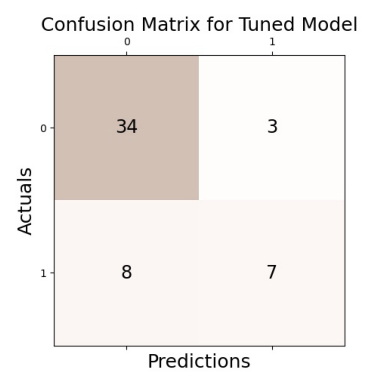

In [107]:
#opening model tuning confusion matrix
model_tune = cv2.imread('/content/hurricane-impact-on-florida-real-estate/modeltuned.jpg',1)
plt.imshow(model_tune)
plt.axis("off")
plt.show()

# Model Validation

In order to know how the model would perform on real world data we will validate it using data from Hurricane Ian. This is data the model has never seen. The model performed with 74% accuracy which is better than the baseline accuracy of 59%. And had an F1 score of 0.533 and an AUC value of 0.92. Of 27 predictions 7 were false negatives and none were false positives.

## XGBoost on Hurricane Ian Data

0    16
1    11
Name: increase, dtype: int64
majority percent is 59.25925925925925 %


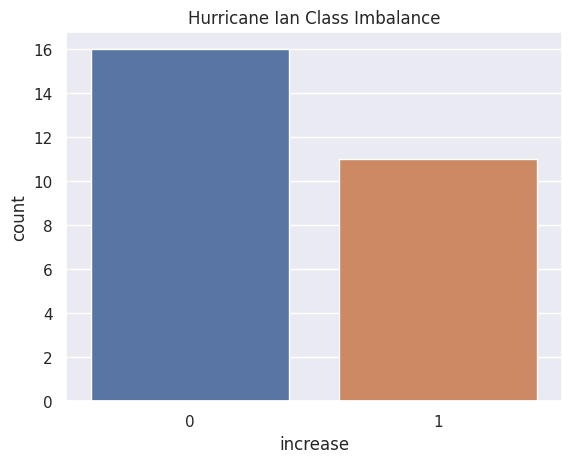

In [108]:
# Checking the balance of target variable 'increase'
#plotting
sns.countplot(x='increase', data=all_ian).set(title='Hurricane Ian Class Imbalance')
#print value counts
print(all_ian['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_ian['increase']) - all_ian['increase'].sum())/(len(all_ian['increase']) - all_ian['increase'].sum()+all_ian['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### Selecting Our Target Variable and Features


In [109]:
#y is target variable
#X is features
y_ian = all_ian['increase']
X_ian = all_ian.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

In [110]:
#getting prediction
y_pred = xgb.predict(X_ian)

In [111]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_ian, y_pred))

Accuracy: 0.741


In [112]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_ian, y_pred))

F1 Score: 0.533


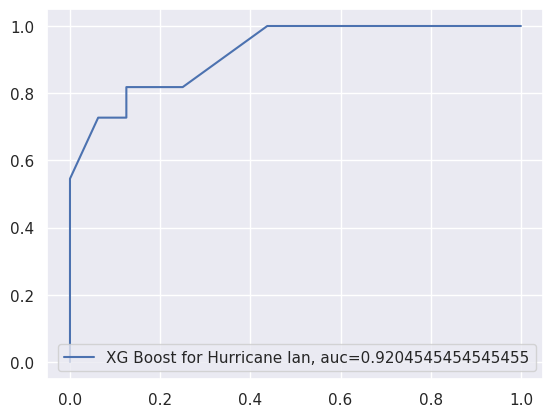

In [113]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(X_ian)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_ian,  y_pred_prob)
auc = metrics.roc_auc_score(y_ian, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="XG Boost for Hurricane Ian, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Confusion Matrix

As seen below 7 false negatives were predicted. Meaning home value was predicted not to increase, but it did.

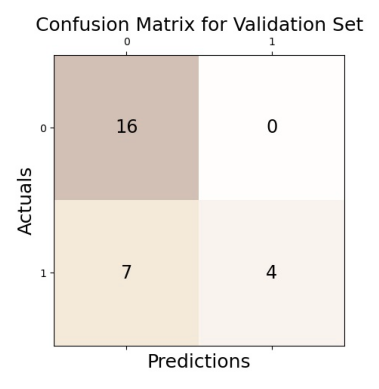

In [114]:
#opening confusion_matrix for validation model
confusion_matrix_valid = cv2.imread('/content/hurricane-impact-on-florida-real-estate/cmmodelvalid.jpg',1)
plt.imshow(confusion_matrix_valid)
plt.axis("off")
plt.show()

# Recommendations
- I recommend further looking into cities that have large Size Ranks and lower than average housing prices as a predictor, regardless of if a hurricane happened because it is a strong indicator of home value. Hurricane features do slightly improve model performance and should also be considered.     

- Wind speed features have a correlation that is similar to that of SizeRank and before prices, hence, it may be an indicator of home value increase and it is relatively relevant to models predictions.     

- I recommend using the model to attempt to buy homes after the next hurricane to see if the model is effective in making business decisions.      

# Further Improvements
Further improvements for this project would be to continue collecting data. For the scope of this project I looked at all hurricanes that were a category 4 or above for the last twenty years. I recommend continuing at all hurricane data that also has real estate data available.       

I also recommend looking at a different region which is impacted by hurricanes, such as Texas, to see what other features could be of importance while modeling.      

# Contact Me
If you have any further questions please contact me at samgrasland@gmail.com!